# Simulating protocol 3, cell 5

In this notebook, I'll use Michaels method 3 parameters to simulate protocol 3 and get synthetic data similar to the real data for cell 5. 

To get an idea on how I compared the multiple parameter sets check the norebook called Kylie..._synth_parameterExplo_notebook...

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. The protocols that I have the myokit version are 2, 3, 4, 5

- First load the data
- compare ODE solution and data
- check if the estimate for N matches the new parameters
- simulate synt data

In [21]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
from scipy.interpolate import interp1d

from scipy.optimize import minimize, minimize_scalar#, curve_fit
import cma
from sklearn.linear_model import LinearRegression

In [22]:
def SRexpo_spline(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    
    residuals = expo_splines - data
    return sum(residuals**2)

def SRexpo_spline_weight(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    #weight = np.exp(-(times-deltat)) / sum(np.exp(-(times-deltat)))
    weight =  1 / (1 + 9 * ((times - deltat)>10) + 90 * ((times - deltat)>100) +  900 * ((times - deltat)>1000))
    residuals = (expo_splines - data) 
    return sum((residuals**2) * weight)

def expo_spline(times, deltat, params, expo_4):
    # three_expo = flag to calculate 2 or 3 exponentials. Default == False. If true, we'll be fitting sum of 3 expo
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    return expo_splines

def Quadratic_fit_for_N(N, x, data):
    quadratic_fit = x * (1 - x / N) 
    residuals = quadratic_fit - data
    return sum(residuals**2)

## Meta parameters

In [72]:
times_to_skip = 50 
NumExpo_flag = True # We will use 4 exponentials
saved_synthdata = True
saved_splines = True
saved_splines_WithNoise = False

N_lower = 10000
N_upper = 70000
FileNameNLower = 'protocol3_cell5_sim_pars_M_M1_N_lower_' + str(N_lower)
FileNameNUpper = 'protocol3_cell5_sim_pars_M_M1_N_upper_' + str(N_upper)

if saved_splines:
    print('This code will load the splines parameters instead of fitting them')

This code will load the splines parameters instead of fitting them


## Load the data and simulate it

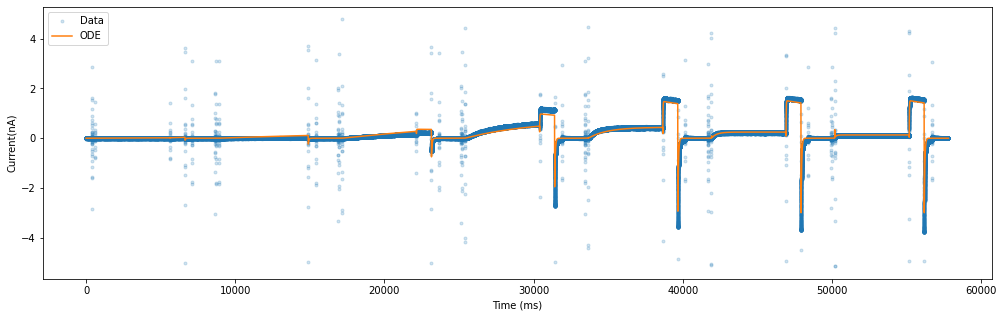

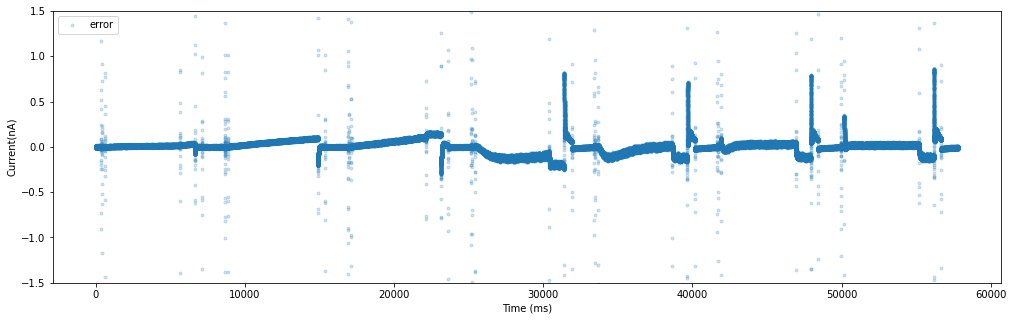

In [3]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov-M-M3.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
#protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
markov_model = myokit.lib.markov.LinearModel.from_component(model.get('ikr'), parameters=parameters)
# Create an analytical simulation 
markov_sim_pr3 = myokit.lib.markov.AnalyticalSimulation(markov_model, protocol_3)
# Log times will be equal to the times from the data
hh_log_pr3 = markov_sim_pr3.run(pr3_time[-1] + 0.1, log_times=pr3_time)


plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current(nA)')
plt.plot(pr3_time, pr3_current, '.', alpha = 0.2,label='Data')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'], '-', label='ODE')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current(nA)')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr']-pr3_current, '.', alpha = 0.2, label='error')
plt.legend(loc='upper left')
plt.ylim([-1.5,1.5])
plt.show()


## Stochastic simulation

For the parameters from Michael M3, the corresponding N is:

$$N = \frac{G_{kr}}{g_{kr}} = \frac{0.133898 \mu S}{2\text{ or } 13.5 pS}.$$
So, 
$$N_U = 66 949, \quad N_l = 9 918$$

I'll simulate:
$$N_U = 70000, \quad N_l = 10000$$ 

In [4]:
# Parameters
seed_m = 1
np.random.seed(seed_m)

if saved_synthdata:
    print('Loading synthetic data for N_upper = 70,000')
    I_grid_pr3_N_upper = np.load(FileNameNUpper + '_I_inter.npy' )
    O_grid_pr3_N_upper = np.load(FileNameNUpper + '_O_inter.npy' )
    print('DONE')
else:
# define the simulations and simualte
    sim_pr3_N_lower = myokit.lib.markov.DiscreteSimulation(markov_model, protocol_3, nchannels = N_lower)
    sim_pr3_N_upper = myokit.lib.markov.DiscreteSimulation(markov_model, protocol_3, nchannels = N_upper)
    print('Running simulation for N_l = ', N_lower)
    log_pr3_N_lower = sim_pr3_N_lower.run(pr3_time[-1] + 0.1)
    print('N_l DONE')
    print('Running simulation for N_U = ', N_upper)
    log_pr3_N_upper = sim_pr3_N_upper.run(pr3_time[-1] + 0.1)
    print('N_U DONE')
    # Save the opening and current track, and separated them into the same time steps as the data
    print('Interpolating for N_l')
    O_pr3_N_lower = np.array(log_pr3_N_lower['ikr.y3']) 
    I_pr3_N_lower = np.array(log_pr3_N_lower['ikr.IKr'])
    time_full_pr3_N_lower = np.array(log_pr3_N_lower['engine.time'])
    O_inter = interp1d(time_full_pr3_N_lower, O_pr3_N_lower,'previous', fill_value = "extrapolate")
    O_grid_pr3_N_lower = O_inter(pr3_time)
    I_inter = interp1d(time_full_pr3_N_lower, I_pr3_N_lower,'previous', fill_value = "extrapolate")
    I_grid_pr3_N_lower = I_inter(pr3_time)
    print('Interpolating for N_U')
    O_pr3_N_upper = np.array(log_pr3_N_upper ['ikr.y3']) 
    I_pr3_N_upper = np.array(log_pr3_N_upper['ikr.IKr'])
    time_full_pr3_N_upper = np.array(log_pr3_N_upper['engine.time'])
    O_inter = interp1d(time_full_pr3_N_upper, O_pr3_N_upper,'previous', fill_value = "extrapolate")
    O_grid_pr3_N_upper = O_inter(pr3_time)
    I_inter = interp1d(time_full_pr3_N_upper, I_pr3_N_upper,'previous', fill_value = "extrapolate")
    I_grid_pr3_N_upper = I_inter(pr3_time)
    print('Saving the simulation')
    np.save(FileNameNLower + '_I_inter.npy' ,I_grid_pr3_N_lower)
    np.save(FileNameNLower + '_O_inter.npy' ,O_grid_pr3_N_lower)
    np.save(FileNameNUpper + '_I_inter.npy' ,I_grid_pr3_N_upper)
    np.save(FileNameNUpper + '_O_inter.npy' ,O_grid_pr3_N_upper)
    print('DONE')



Loading synthetic data for N_upper = 70,000
DONE


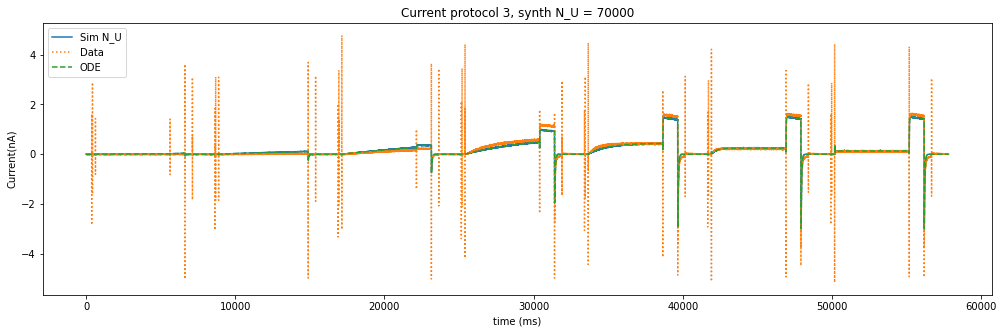

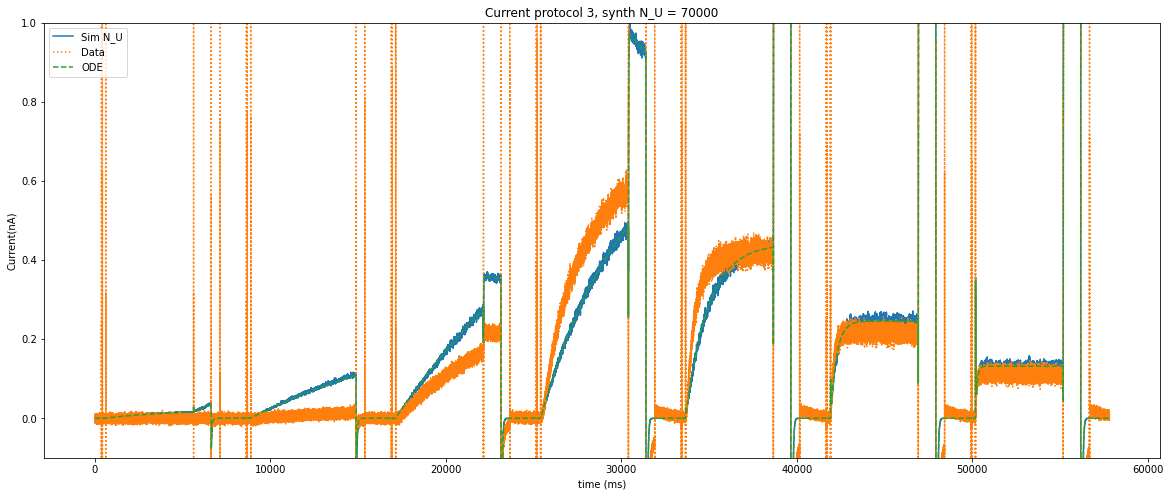

In [9]:
# Let's compare the simulation vs data 1.
plt.figure(figsize=(17, 5))
plt.plot(pr3_time, I_grid_pr3_N_upper ,'-', drawstyle='steps-post', label='Sim N_U')
plt.plot(pr3_time, pr3_current,':', drawstyle='steps-post', label='Data')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'],'--', drawstyle='steps-post', label='ODE')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, synth N_U = ' + str(N_upper))
plt.legend(loc='upper left')

plt.show()

plt.figure(figsize=(20, 8))
plt.plot(pr3_time, I_grid_pr3_N_upper ,'-', drawstyle='steps-post', label='Sim N_U')
plt.plot(pr3_time, pr3_current,':', drawstyle='steps-post', label='Data')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'],'--', drawstyle='steps-post', label='ODE')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, synth N_U = ' + str(N_upper))
plt.legend(loc='upper left')
plt.ylim(-.1, 1)

plt.show()

## Separate by voltage and define color scheme

In [18]:
# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
I_grid_pr3_N_upper_constV = {}
I_grid_pr3_N_upper_constV_without_first5ms ={}
O_grid_pr3_N_upper_constV = {}
O_grid_pr3_N_upper_constV_without_first5ms ={}

for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    I_grid_pr3_N_upper_constV[i] = I_grid_pr3_N_upper[pr3_Vtimes[i] :(pr3_Vtimes[i+1]-1)]
    O_grid_pr3_N_upper_constV[i] = O_grid_pr3_N_upper[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    I_grid_pr3_N_upper_constV_without_first5ms[i] = I_grid_pr3_N_upper[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    O_grid_pr3_N_upper_constV_without_first5ms[i] = O_grid_pr3_N_upper[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))

# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])

42


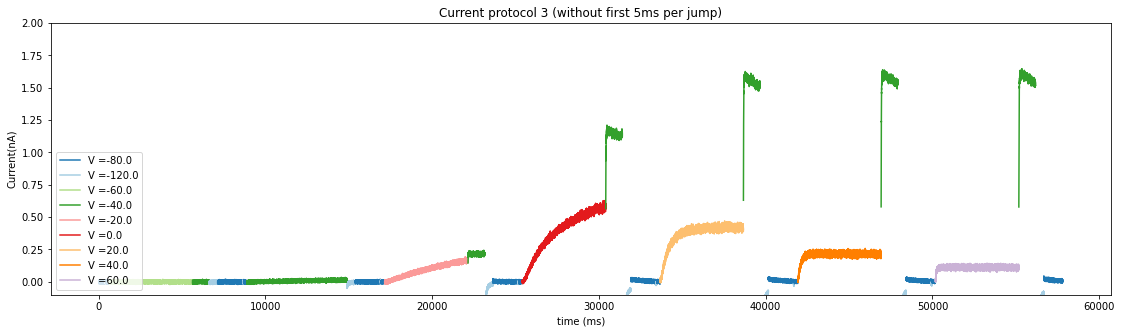

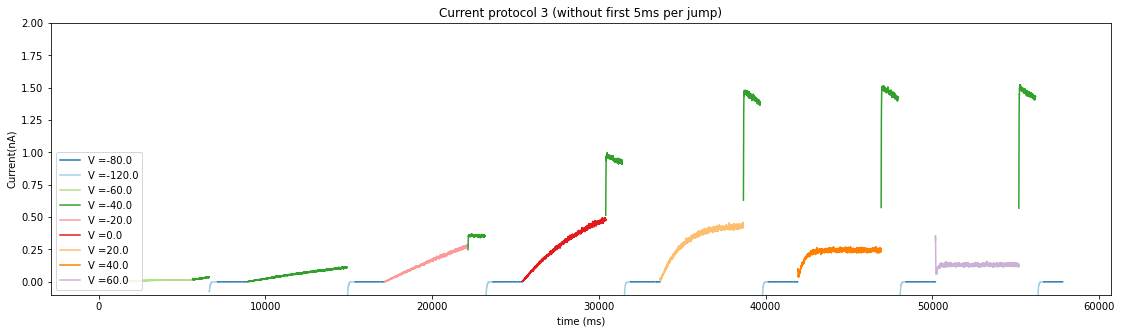

In [15]:
plt.figure(figsize=(19, 5))
#plt.plot(pr3_time,pr3_current,':', label = 'Full current')
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time_constV_without_first5ms[i], pr3_current_constV_without_first5ms[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylim([-.1,2])
plt.ylabel('Current(nA)')
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(19, 5))
#plt.plot(pr3_time,pr3_current,':', label = 'Full current')
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time_constV_without_first5ms[i], I_grid_pr3_N_upper_constV_without_first5ms[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.ylim([-.1,2])
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()

## Separate the V >=40

In [16]:
print(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = np.nonzero(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = index_largerCurrents[0]
print(len(index_largerCurrents))

times_largerCurrents = [None] * len(index_largerCurrents)
I_grid_pr3_largerCurrents = [None] * len(index_largerCurrents)
I_grid_pr3_deltat_largerCurrents = np.zeros(len(index_largerCurrents))

#I_grid_pr3_splines_largerCurrents = [None] * len(index_largerCurrents)
#I_grid_pr3_splines_params_largerCurrents = [None] * len(index_largerCurrents)
#I_grid_pr3_residuals2_largerCurrents = [None] * len(index_largerCurrents)

I_grid_pr3_splines_largerCurrents_weights = [None] * len(index_largerCurrents)
I_grid_pr3_splines_params_largerCurrents_weights= [None] * len(index_largerCurrents)
I_grid_pr3_residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)

# Separate times and currents:

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    times_largerCurrents[index_i] = pr3_time_constV_without_first5ms[i]
    I_grid_pr3_largerCurrents[index_i] = I_grid_pr3_N_upper_constV_without_first5ms[i]
    I_grid_pr3_deltat_largerCurrents[index_i] =  times_largerCurrents[index_i][0]

[False False False False  True False False False False  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False]
12


In [42]:
# Also separate the ode solutions

I_ode_pr3 = hh_log_pr3['ikr.IKr']
I_ode_pr3_constV = {}
I_ode_pr3_constV_without_first5ms = {}
I_ode_pr3_largerCurrents = [None] * len(index_largerCurrents)
I_ode_pr3_residuals2_largerCurrents = [None] * len(index_largerCurrents)


for i in range(len(pr3_Vtimes)-1):
    I_ode_pr3_constV[i]= I_ode_pr3[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    I_ode_pr3_constV_without_first5ms[i] = I_ode_pr3[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    I_ode_pr3_largerCurrents[index_i] = I_ode_pr3_constV_without_first5ms[i]


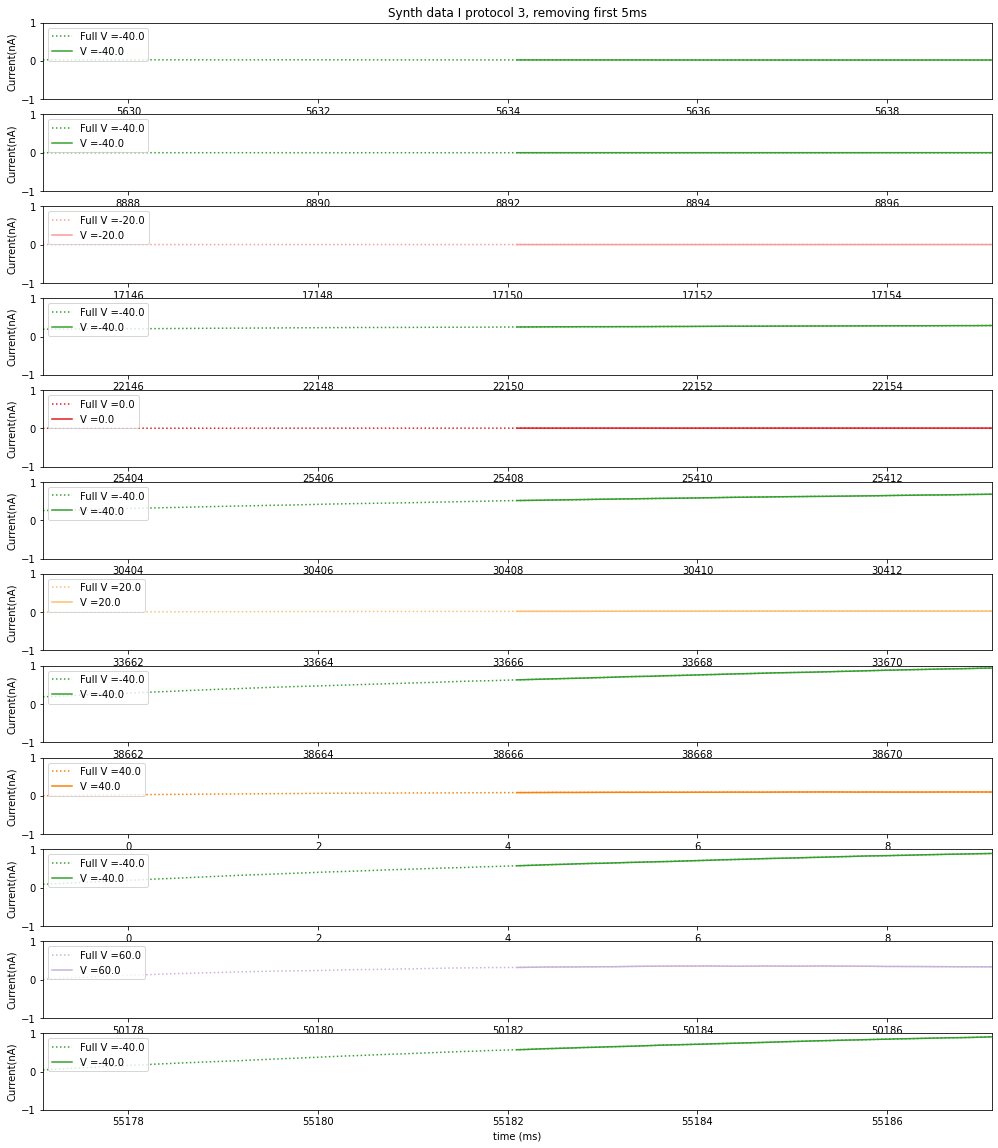

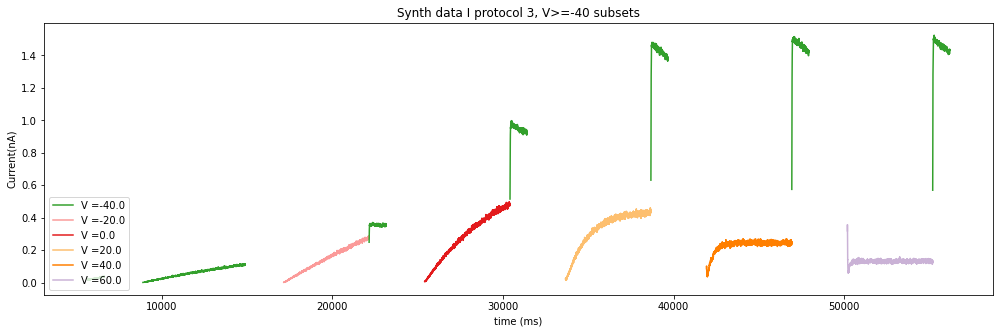

In [19]:

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 20))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    axs[index_i].plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], I_grid_pr3_N_upper_constV[i],':',color = pr3_voltage_constV_colors[i], label='Full ' + pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylim([-1,1])
    axs[index_i].set_xlim([pr3_time[pr3_Vtimes[i]],pr3_time[pr3_Vtimes[i]]+10])
    if index_i == 0:
        axs[index_i].set_title('Synth data I protocol 3, removing first 5ms')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 5))
#plt.plot(pr3_time, pr3_current,':', label='Full protocol')
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Synth data I protocol 3, V>=-40 subsets')
    plt.legend(loc='lower left')
plt.show()

In [23]:
# Find or load the splines parameters. NO WEIGHTS
if saved_splines:
    # Load the parameters of the spline:
    I_grid_pr3_splines_params_largerCurrents_weights = np.load(FileNameNUpper + '_I_inter_par_splinesWeights.npy')
    for index_i in range(len(index_largerCurrents)): 
        I_grid_pr3_splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    print('Loading with weights DONE')
else:
    # CMA fit weights
    for index_i in range(len(index_largerCurrents)): 
        i=index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [I_grid_pr3_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [I_grid_pr3_largerCurrents[index_i][-1],I_grid_pr3_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i], NumExpo_flag], options = optscma)
        I_grid_pr3_splines_params_largerCurrents_weights[index_i] = es[0]
        I_grid_pr3_splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    # SAVE THE PARAMETERS
    np.save(FileNameNUpper + '_I_inter_par_splinesWeights.npy',np.array(I_grid_pr3_splines_params_largerCurrents_weights))
    print('Fitting with weights DONE')

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=818677, Sun Oct 31 19:48:21 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.004685850834961e+01 1.0e+00 9.83e-01  1e+00  1e+00 0:00.0
    2     20 2.816455261280427e+01 1.2e+00 9.12e-01  9e-01  1e+00 0:00.0
    3     30 4.419926093644113e-01 1.3e+00 8.73e-01  8e-01  9e-01 0:00.1
  100   1000 8.529686519504617e-04 9.7e+01 2.26e-02  4e-03  4e-02 0:01.6
  200   2000 2.485496982739542e-04 1.6e+03 3.86e-03  8e-05  7e-03 0:03.0
  300   3000 2.289537320682861e-04 3.6e+04 6.43e-03  2e-05  4e-02 0:04.4
  400   4000 2.281724993097017e-04 5.1e+04 3.43e-02  3e-05  1e-01 0:05.9
NOTE (module=cma, iteration=452):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.2e+10 to 2.0e+09
  500   5000 2.272977191879263e-04 8.7e+04 1.59e-01  5e-05  1e+00 0:07.3
  600   6000 2.204716640690014e-04 7.0e+05 3.64e-01  6e-05  8e+00 0:08.7


/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=625)
  warnings.warn(msg + ' (' +


  700   7000 2.194365741866299e-04 2.1e+01 3.99e-02  2e-02  6e-02 0:10.1
  800   8000 2.192709836998319e-04 2.1e+02 7.47e-01  5e-01  5e+00 0:11.6
  900   9000 2.190139387256330e-04 3.4e+02 1.05e+00  4e-01  4e+00 0:13.0
 1000  10000 2.189540808267076e-04 1.4e+03 1.54e-01  2e-02  3e-01 0:14.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 2.189316796853855e-04 3.7e+03 1.40e+00  1e-01  5e+00 0:15.9
 1200  12000 2.189059654143352e-04 2.5e+03 3.39e+00  8e-02  5e+00 0:17.5
 1300  13000 2.188866122581229e-04 1.9e+03 8.88e+00  2e-01  6e+00 0:19.1
 1400  14000 2.188682179984651e-04 2.2e+03 1.40e+01  1e-01  7e+00 0:20.7
 1500  15000 2.188574588256093e-04 1.8e+03 1.57e+01  1e-01  4e+00 0:22.2
 1600  16000 2.188482891691010e-04 1.7e+03 3.41e+01  1e-01  3e+00 0:23.8
 1700  17000 2.188413428272205e-04 3.6e+03 4.58e+01  8e-02  2e+00 0:25.3
 1800  18000 2.188365589418007e-04 3.7e+03 1.05e+02  1e-01  2e+00 0:26.9
 1900  19000 2.188328715810568e-04 4.8e+03 2.05e+02 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=503)
  warnings.warn(msg + ' (' +


  600   6000 3.144705942834454e-04 6.0e+01 2.25e-02  7e-03  3e-02 0:43.6
  646   6460 3.144704992532756e-04 1.6e+02 1.09e-03  2e-04  2e-03 0:46.9
termination on tolfun=1e-11 (Sun Oct 31 19:53:59 2021)
final/bestever f-value = 3.144705e-04 3.144705e-04
incumbent solution: [ 2.30916086e-01 -1.42397826e+02  5.81453557e+03  1.42173570e+02
  5.81025917e+03 -6.15168264e-03  3.08024309e+03  9.17502289e-04 ...]
std deviations: [0.00086093 0.00061668 0.00097273 0.00078171 0.0002914  0.0010205
 0.00122137 0.00022101 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=885583, Sun Oct 31 19:53:59 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.197514272839915e+01 1.0e+00 9.38e-01  9e-01  1e+00 0:00.1
    2     20 1.433283381174617e+01 1.2e+00 9.45e-01  9e-01  1e+00 0:00.1
    3     30 1.073578960287001e+01 1.3e+00 9.02e-01  8e-01  1e+00 0:00.2
   55    550 6.839580907107883e-01 1.7e+01 1.69e-01  8e-02  2e-01 0:03.2
  100   1000 7.9749639617434

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=702)
  warnings.warn(msg + ' (' +


  800   8000 1.036444207598043e-03 4.5e+01 3.73e-01  2e-01  1e+00 0:47.6
  900   9000 1.036393764819262e-03 2.3e+02 1.08e+00  4e-01  3e+00 0:53.7
 1000  10000 1.036329383178642e-03 6.9e+02 2.21e+00  6e-01  4e+00 1:00.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.036193854514977e-03 2.4e+03 9.68e+00  3e+00  2e+01 1:06.4
 1200  12000 1.035862134809784e-03 1.3e+04 1.66e+01  1e+01  7e+01 1:12.6
 1300  13000 1.035608578928190e-03 2.9e+04 5.23e+01  3e+01  2e+02 1:18.9
 1400  14000 1.035545401571367e-03 1.3e+05 5.46e+01  4e+01  4e+02 1:25.0
 1500  15000 1.035531333530535e-03 1.3e+05 6.04e+01  2e+01  2e+02 1:31.3
 1600  16000 1.035527786429081e-03 1.1e+05 5.02e+01  7e+00  8e+01 1:37.5
 1700  17000 1.035526884218434e-03 2.4e+05 1.12e+02  1e+01  1e+02 1:43.9
 1800  18000 1.035526193857862e-03 2.9e+05 2.84e+02  1e+01  1e+02 1:50.0
 1900  19000 1.035521410102096e-03 7.2e+05 7.33e+02  4e+01  7e+02 1:56.3
 2000  20000 1.035519693299383e-03 9.9e+05 8.32e+02 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=623)
  warnings.warn(msg + ' (' +


  700   7000 3.340588362850765e-03 7.1e+01 9.15e-01  6e-01  2e+00 0:09.8
  800   8000 3.209053776265152e-03 4.3e+02 2.87e+00  2e+00  1e+01 0:11.2
  900   9000 3.057099188141889e-03 5.6e+03 5.67e+00  4e+00  4e+01 0:12.5
 1000  10000 3.014519211779103e-03 6.8e+04 6.35e+00  3e+00  8e+01 0:13.9
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 2.999959620866702e-03 3.6e+05 1.03e+01  5e+00  8e+01 0:15.4
 1200  12000 2.992284229451009e-03 1.4e+06 2.30e+01  2e+01  2e+02 0:16.9
 1300  13000 2.989908947494659e-03 5.2e+06 3.35e+01  3e+01  2e+02 0:18.5
 1363  13630 2.989315270101746e-03 1.0e+07 5.16e+01  2e+01  2e+02 0:19.5
termination on tolconditioncov=100000000000000.0 (Sun Oct 31 20:04:19 2021)
final/bestever f-value = 2.989309e-03 2.989306e-03
incumbent solution: [ 4.33000341e-01 -7.33350863e+02  1.95016384e+04  7.33275314e+02
  1.94977140e+04  5.17531000e-01  1.89895855e+01 -6.27233934e-01 ...]
std deviations: [ 20.89353248 106.47654979 230.856815   110.15

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=631)
  warnings.warn(msg + ' (' +


  700   7000 3.094549536655404e-03 4.2e+01 1.35e-01  7e-02  5e-01 0:41.4
  800   8000 3.094412429463450e-03 9.4e+02 1.31e+00  5e-01  1e+01 0:47.5
  900   9000 3.094235861655140e-03 1.7e+03 2.26e+00  7e-01  9e+00 0:54.0
 1000  10000 3.094124993562698e-03 4.3e+03 1.77e+00  3e-01  5e+00 1:00.3
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 3.094053044180806e-03 1.7e+04 4.23e+00  1e+00  2e+01 1:06.5
 1200  12000 3.094040760778470e-03 1.8e+04 7.41e+00  2e+00  2e+01 1:12.9
 1300  13000 3.094022047616312e-03 3.7e+04 1.35e+01  2e+00  4e+01 1:19.1
 1400  14000 3.093883590367971e-03 6.9e+04 5.64e+01  1e+01  2e+02 1:25.5
 1500  15000 3.093572686369597e-03 8.6e+04 8.03e+01  2e+01  2e+02 1:32.1
 1600  16000 3.093373829802274e-03 5.7e+04 2.37e+02  2e+01  3e+02 1:38.4
 1700  17000 3.092932067575895e-03 3.0e+04 3.76e+02  7e+00  1e+02 1:44.6
 1800  18000 3.092333117254863e-03 2.6e+04 2.12e+03  1e+01  2e+02 1:50.8
 1900  19000 3.091276564760876e-03 3.2e+04 3.30e+03 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1312)
  warnings.warn(msg + ' (' +


 1400  14000 1.151340446366975e-02 1.8e+01 1.30e+00  5e-01  3e+00 0:19.9
 1500  15000 1.151340289765646e-02 1.2e+02 2.94e+00  6e-01  8e+00 0:21.5
 1600  16000 1.151340122390072e-02 2.4e+02 5.82e+00  5e-01  1e+01 0:23.0
 1700  17000 1.151339936244607e-02 6.7e+02 1.61e+01  7e-01  3e+01 0:24.7
 1800  18000 1.151339727018920e-02 1.7e+03 2.86e+01  1e+00  5e+01 0:26.3
 1900  19000 1.151339370832063e-02 7.7e+03 1.10e+02  4e+00  3e+02 0:27.9
 2000  20000 1.151329127625850e-02 1.6e+04 3.43e+02  8e+00  3e+02 0:29.5
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 2100  21000 1.151318113015528e-02 1.7e+04 4.90e+02  1e+01  2e+02 0:31.1
 2200  22000 1.151315503535165e-02 1.1e+04 2.20e+03  2e+01  4e+02 0:32.7
 2300  23000 1.151311146723415e-02 9.4e+03 2.71e+03  1e+01  2e+02 0:34.3
 2400  24000 1.151304923688949e-02 1.0e+04 6.54e+03  1e+01  2e+02 0:35.9
 2439  24390 1.151299177944880e-02 2.4e+04 2.04e+04  2e+01  1e+03 0:36.6
termination on tolfacupx=1000.0 (Sun Oct 31 20:22:23

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=766)
  warnings.warn(msg + ' (' +


  800   8000 6.700332023849588e-03 5.0e+00 8.81e-02  6e-02  2e-01 0:48.3
  900   9000 6.700011805348842e-03 5.0e+02 1.23e+00  1e+00  3e+01 0:54.6
 1000  10000 6.699771468903956e-03 1.3e+03 5.77e+00  2e+00  3e+01 1:01.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 6.699436244940959e-03 2.8e+03 6.17e+00  7e-01  2e+01 1:07.4
 1200  12000 6.698344210457684e-03 7.7e+03 2.62e+01  2e+00  6e+01 1:13.6
 1300  13000 6.695755665960874e-03 1.5e+04 2.74e+01  1e+00  3e+01 1:20.0
 1400  14000 6.694724517545722e-03 1.5e+04 5.86e+01  1e+00  2e+01 1:26.1
 1500  15000 6.692946154733035e-03 1.1e+04 2.51e+02  3e+00  3e+01 1:32.4
 1600  16000 6.690045740553613e-03 2.6e+04 4.39e+02  4e+00  7e+01 1:38.7
 1700  17000 6.688504610887729e-03 2.6e+04 2.78e+02  1e+00  2e+01 1:45.0
 1800  18000 6.688439259526149e-03 6.9e+04 6.44e+00  2e-02  4e-01 1:51.1
 1809  18090 6.688439259413061e-03 6.1e+04 4.70e+00  2e-02  3e-01 1:51.6
termination on tolfun=1e-11 (Sun Oct 31 20:25:58 202

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=935)
  warnings.warn(msg + ' (' +


 1000  10000 1.512340438031455e-02 1.0e+01 9.08e-01  4e-01  2e+00 0:14.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.511782993068873e-02 3.6e+01 3.26e+00  1e+00  7e+00 0:15.6
 1200  12000 1.510883017190667e-02 1.1e+02 8.36e+00  1e+00  2e+01 0:17.1
 1300  13000 1.508676423827068e-02 2.6e+02 2.07e+01  1e+00  3e+01 0:18.7
 1400  14000 1.505202336479023e-02 5.9e+02 3.97e+01  1e+00  5e+01 0:20.2
 1500  15000 1.495252262819654e-02 1.1e+03 1.39e+02  3e+00  1e+02 0:21.8
 1600  16000 1.455876034434114e-02 3.5e+03 7.51e+02  1e+01  4e+02 0:23.4
 1700  17000 1.381371873343715e-02 2.6e+04 8.08e+02  1e+01  5e+02 0:25.1
 1781  17810 1.358480485972871e-02 1.6e+05 8.97e+02  1e+01  1e+03 0:26.4
termination on tolfacupx=1000.0 (Sun Oct 31 20:27:48 2021)
final/bestever f-value = 1.358412e-02 1.358314e-02
incumbent solution: [ 1.22381514e+00 -5.81897453e+01  8.28447361e+02  5.84200016e+01
  8.31976871e+02  2.49152061e-01  2.58187424e+01 -1.07019759e+00 ...]
std de

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=869)
  warnings.warn(msg + ' (' +


  900   9000 1.705037262456321e-02 7.8e+00 8.34e-01  6e-01  2e+00 0:53.9
 1000  10000 1.699237076466210e-02 2.7e+02 1.07e+01  4e+00  1e+02 1:00.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.687883237079332e-02 5.8e+02 2.90e+01  5e+00  6e+01 1:06.5
 1200  12000 1.643151189804698e-02 2.9e+03 1.21e+02  2e+01  4e+02 1:12.6
 1300  13000 1.599289562390197e-02 1.0e+04 1.33e+02  1e+01  2e+02 1:18.9
 1400  14000 1.581175466406473e-02 1.3e+04 1.68e+02  2e+01  2e+02 1:25.0
 1500  15000 1.576555142658188e-02 3.6e+04 2.02e+02  1e+01  3e+02 1:31.3
 1600  16000 1.574289665900874e-02 7.3e+04 3.03e+02  1e+01  3e+02 1:37.8
 1700  17000 1.573160946644811e-02 2.3e+05 6.73e+02  2e+01  6e+02 1:44.2
 1800  18000 1.572526114599395e-02 5.3e+05 8.49e+02  2e+01  5e+02 1:50.7
 1883  18830 1.572279499713735e-02 7.4e+05 2.11e+03  4e+01  1e+03 1:55.8
termination on tolfacupx=1000.0 (Sun Oct 31 20:31:35 2021)
final/bestever f-value = 1.572266e-02 1.572266e-02
incumbent solut

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1080)
  warnings.warn(msg + ' (' +


 1100  11000 1.140159513363000e-02 4.6e+00 1.73e+01  2e+01  2e+01 0:15.4
 1200  12000 1.133291116240374e-02 6.4e+01 3.46e+01  2e+01  1e+02 0:17.0
 1300  13000 1.129865808201982e-02 2.5e+02 6.32e+01  3e+01  1e+02 0:18.6
 1400  14000 1.127547590754851e-02 5.3e+02 1.18e+02  4e+01  2e+02 0:20.2
 1500  15000 1.126423848303887e-02 1.3e+03 1.80e+02  4e+01  2e+02 0:21.8
 1600  16000 1.125737424399140e-02 3.4e+03 2.53e+02  4e+01  2e+02 0:23.4
 1700  17000 1.125314619303847e-02 3.2e+03 4.79e+02  4e+01  2e+02 0:24.9
 1800  18000 1.125015960619946e-02 4.8e+03 6.84e+02  4e+01  2e+02 0:26.5
 1900  19000 1.124773886209558e-02 6.9e+03 1.38e+03  4e+01  2e+02 0:28.1
 2000  20000 1.124597443627184e-02 1.2e+04 1.63e+03  3e+01  2e+02 0:29.7
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 2100  21000 1.124488205744840e-02 1.8e+04 2.39e+03  3e+01  1e+02 0:31.3
 2200  22000 1.124415827829397e-02 2.7e+04 4.95e+03  3e+01  2e+02 0:33.0
 2300  23000 1.124359950700094e-02 2.8e+04 1.47e+04 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=875)
  warnings.warn(msg + ' (' +


  900   9000 1.061354063498317e-01 5.1e+00 1.43e+01  1e+01  2e+01 0:57.9
 1000  10000 1.058548835519943e-01 7.9e+01 1.61e+01  7e+00  4e+01 1:04.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.057456859117873e-01 4.1e+02 1.43e+01  4e+00  3e+01 1:10.3
 1200  12000 1.056626244615326e-01 7.0e+02 4.90e+01  1e+01  7e+01 1:16.6
 1300  13000 1.056322232139491e-01 1.8e+03 6.74e+01  1e+01  8e+01 1:23.1
 1400  14000 1.056112135809651e-01 3.8e+03 9.62e+01  8e+00  7e+01 1:29.4
 1500  15000 1.055941525497703e-01 6.6e+03 3.47e+02  3e+01  2e+02 1:35.7
 1600  16000 1.055844612392557e-01 2.6e+04 6.34e+02  4e+01  4e+02 1:42.0
 1700  17000 1.055793271313686e-01 6.4e+04 1.07e+03  6e+01  5e+02 1:48.4
 1776  17760 1.055761924491051e-01 1.2e+05 2.30e+03  1e+02  1e+03 1:53.1
termination on tolfacupx=1000.0 (Sun Oct 31 20:55:01 2021)
final/bestever f-value = 1.055762e-01 1.055762e-01
incumbent solution: [ 3.66682257e-01 -1.86914834e+03  2.67263345e+04  1.86891444e+03
  2

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=553)
  warnings.warn(msg + ' (' +


  600   6000 1.028089600721841e-02 1.6e+01 1.09e-01  8e-02  1e-01 0:08.7
  700   7000 1.028054888636090e-02 3.1e+02 2.44e-01  8e-02  5e-01 0:10.1
  800   8000 1.027944562961787e-02 1.0e+03 6.97e-01  2e-01  2e+00 0:11.4
  900   9000 1.027873144029102e-02 8.9e+02 1.68e+00  4e-01  2e+00 0:12.9
 1000  10000 1.027771247371017e-02 4.1e+03 5.73e+00  1e+00  1e+01 0:14.3
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.027075784937602e-02 2.5e+04 1.49e+01  2e+00  7e+01 0:15.8
 1200  12000 1.026518583222806e-02 8.0e+04 3.10e+01  5e+00  2e+02 0:17.3
 1300  13000 1.026135397307521e-02 9.1e+04 6.27e+01  6e+00  1e+02 0:18.9
 1400  14000 1.025831816029733e-02 1.3e+05 1.36e+02  1e+01  2e+02 0:20.5
 1500  15000 1.025451268666839e-02 1.5e+05 2.95e+02  9e+00  2e+02 0:22.1
 1600  16000 1.024767821736547e-02 3.6e+05 1.00e+03  2e+01  4e+02 0:23.7
 1644  16440 1.024314661753609e-02 1.1e+06 1.68e+03  2e+01  1e+03 0:24.5
termination on tolfacupx=1000.0 (Sun Oct 31 20:56:39

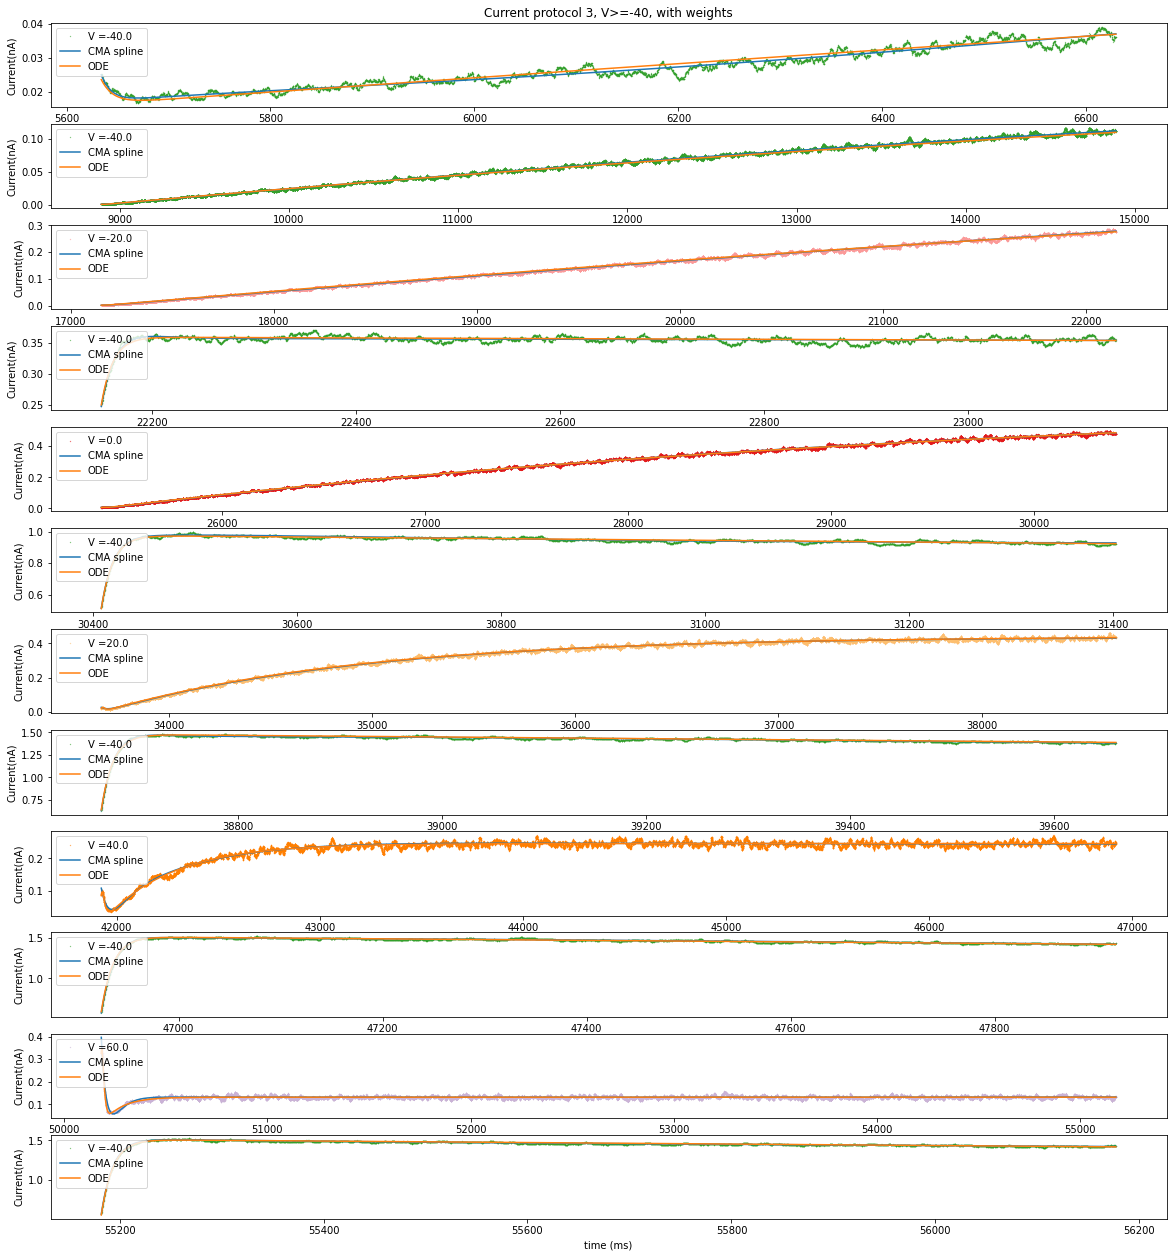

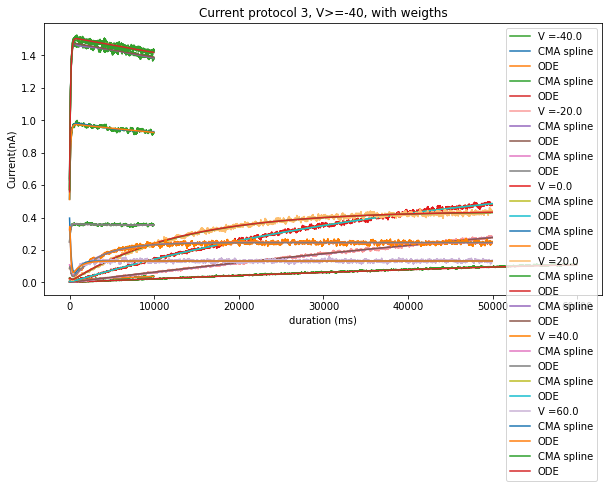

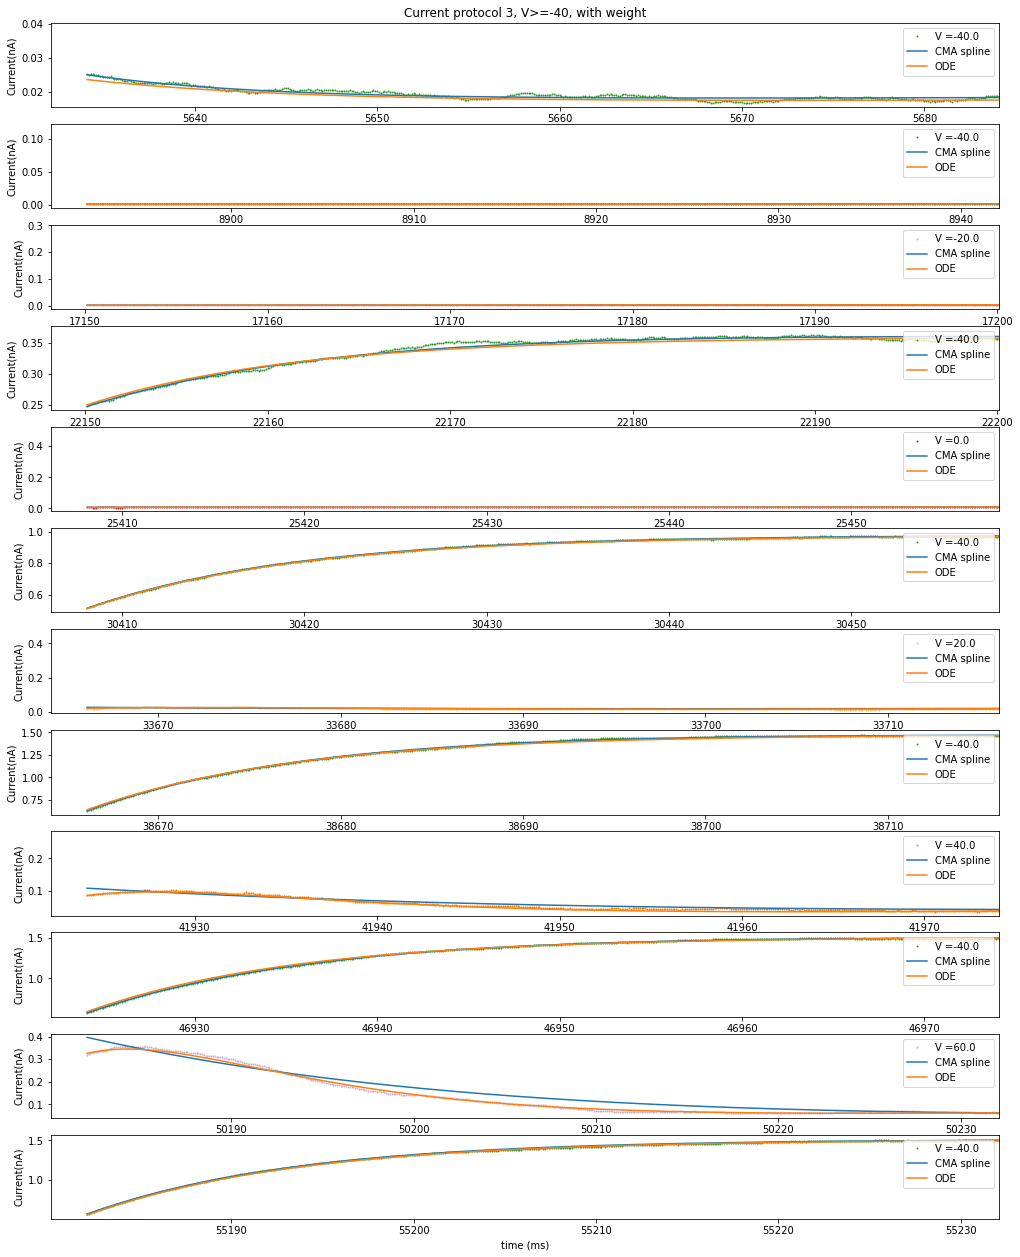

In [41]:
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(20, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i],'.', markersize=.51, color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], I_grid_pr3_splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].plot(times_largerCurrents[index_i], I_ode_pr3_largerCurrents[index_i], label = 'ODE')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(I_grid_pr3_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(I_grid_pr3_splines_largerCurrents_weights[index_i], label = 'CMA spline')
    plt.plot(I_ode_pr3_largerCurrents[index_i], label = 'ODE')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40, with weigths')
plt.legend(loc='upper right')
plt.show()

# Zoom

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i],'.', markersize=2, color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], I_grid_pr3_splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].plot(times_largerCurrents[index_i], I_ode_pr3_largerCurrents[index_i], label = 'ODE')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0]-2,times_largerCurrents[index_i][0]+50])
    #axs[index_i].set_ylim([-.03, I_grid_pr3_splines_largerCurrents_weights[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

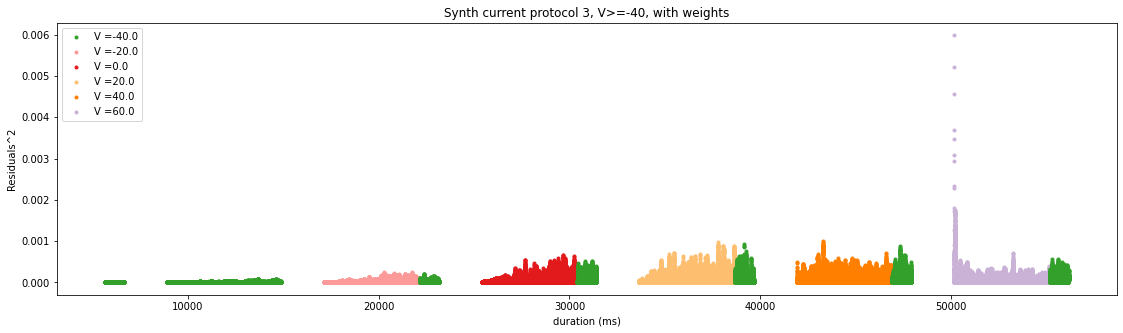

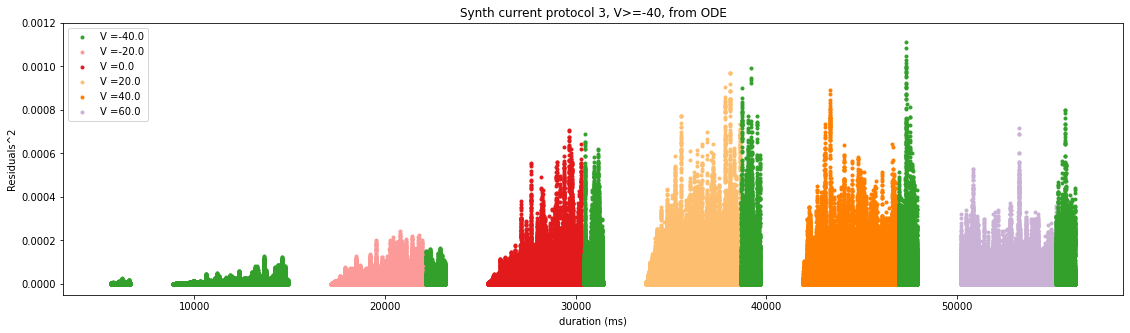

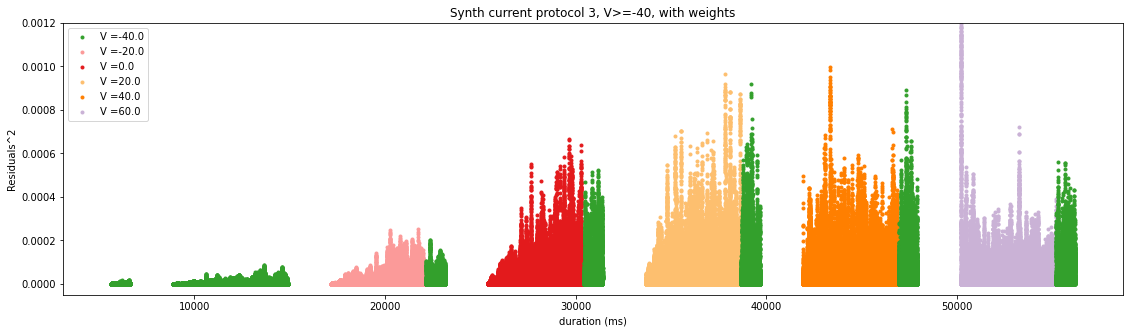

In [49]:
I_grid_pr3_residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)


# Residuals

plt.figure(figsize=(19, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    residuals = I_grid_pr3_largerCurrents[index_i] - I_grid_pr3_splines_largerCurrents_weights[index_i]
    I_grid_pr3_residuals2_largerCurrents_weights[index_i] = residuals ** 2
    residuals = I_grid_pr3_largerCurrents[index_i] - I_ode_pr3_largerCurrents[index_i]
    I_ode_pr3_residuals2_largerCurrents[index_i] = residuals ** 2
    plt.plot(times_largerCurrents[index_i], I_grid_pr3_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Synth current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(19, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], I_ode_pr3_residuals2_largerCurrents[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.ylim([-.00005,0.0012])
plt.title('Synth current protocol 3, V>=-40, from ODE')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(19, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], I_grid_pr3_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.ylim([-.00005,0.0012])
plt.title('Synth current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

[7, (84,), 9]
[9, (93,), 14]
[11, (94,), 17]


<Figure size 1224x360 with 0 Axes>

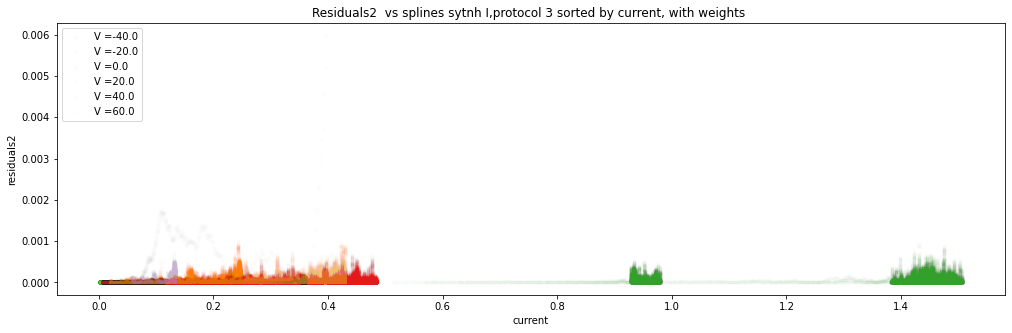

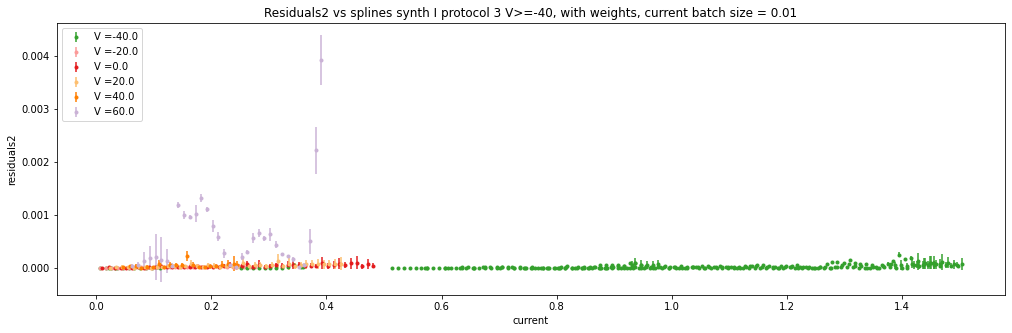

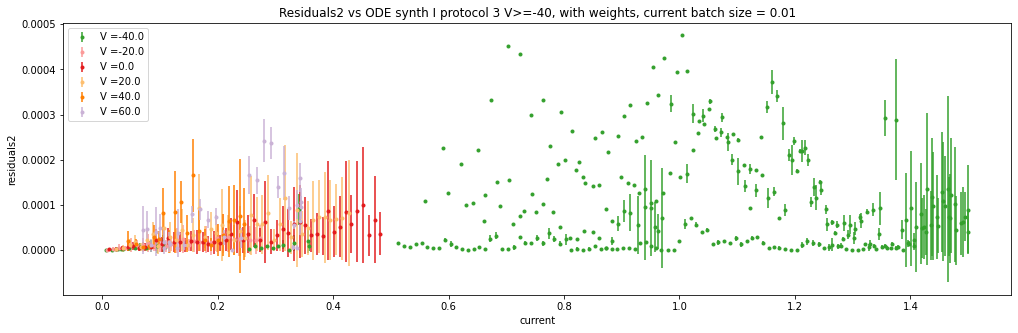

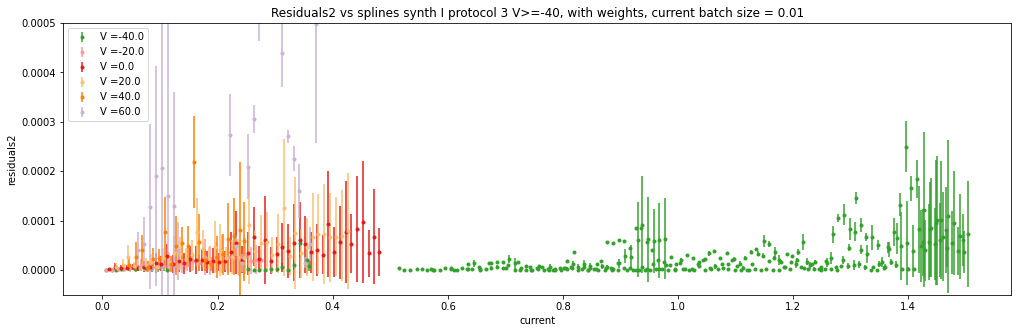

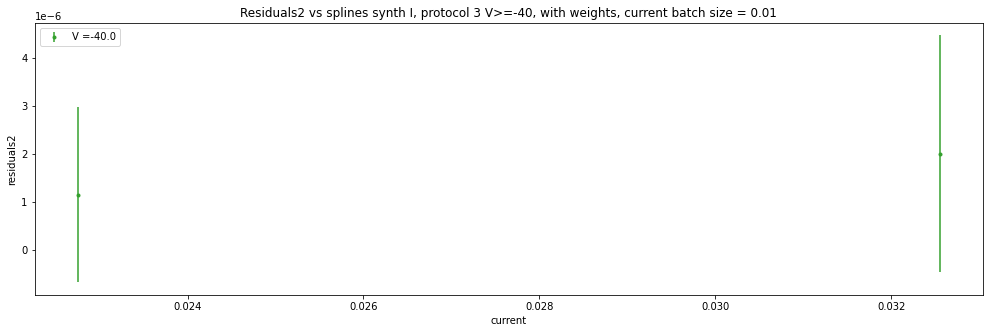

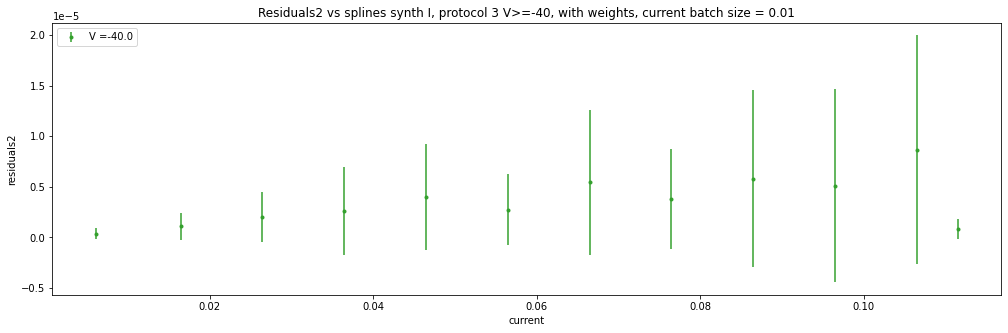

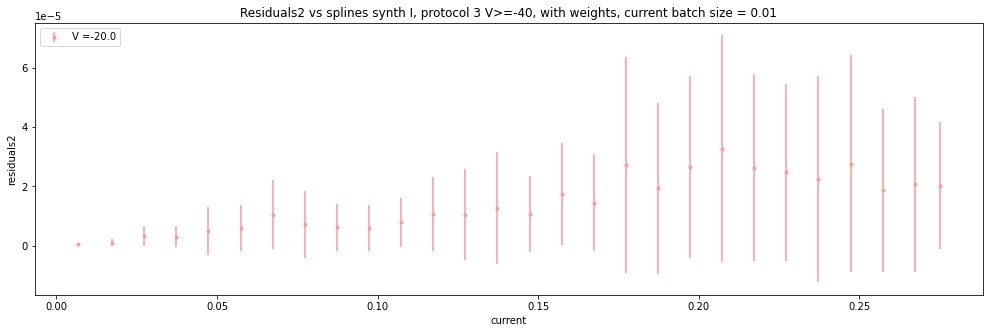

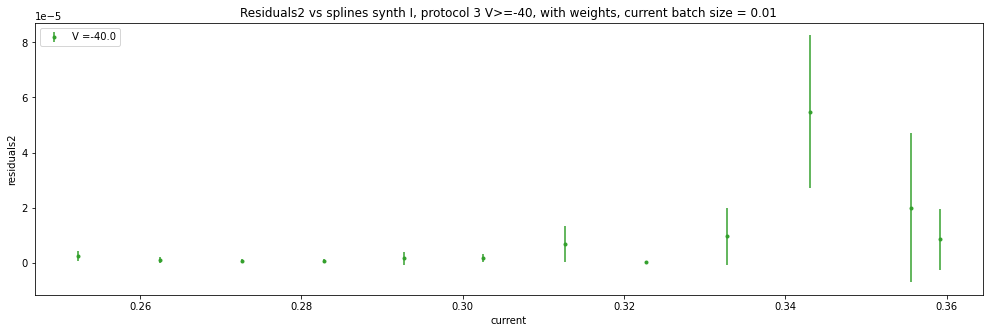

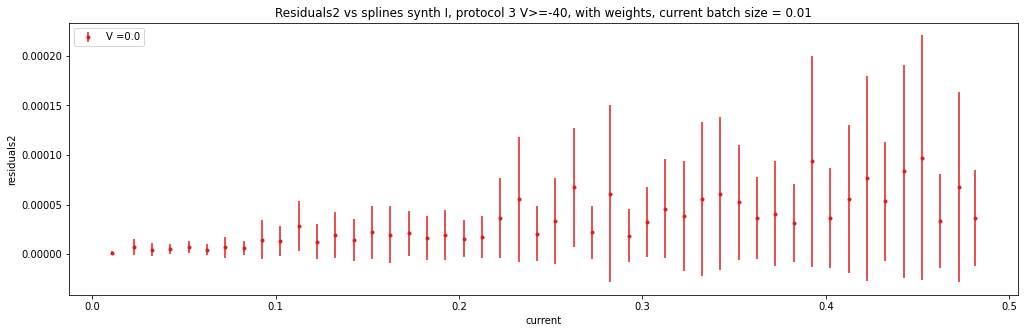

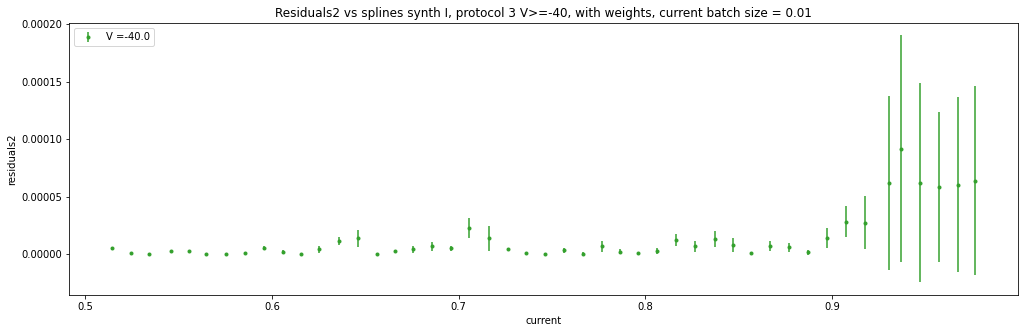

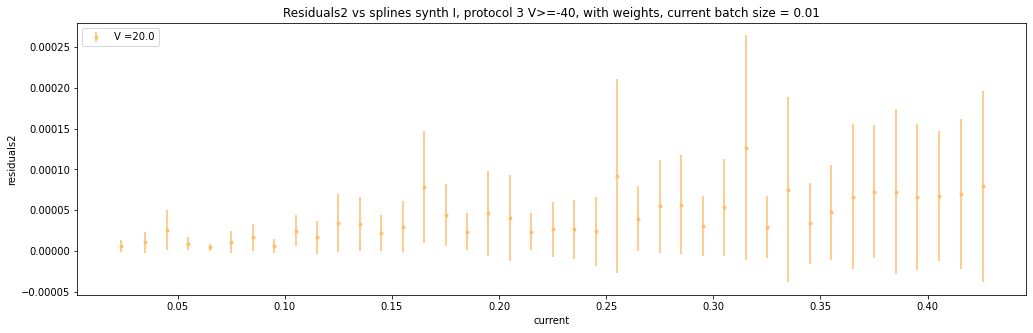

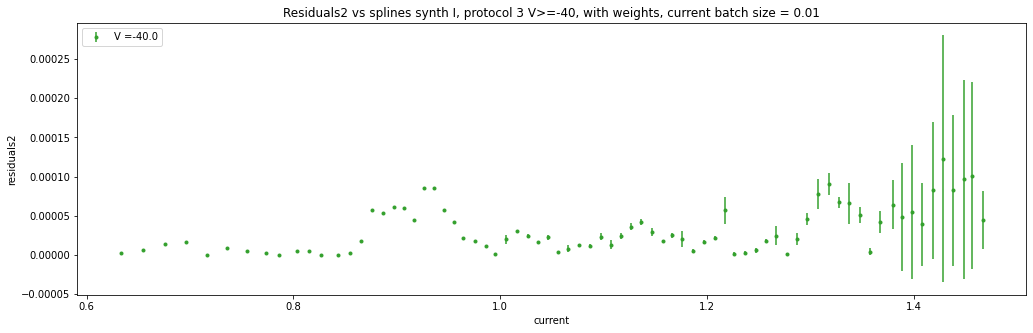

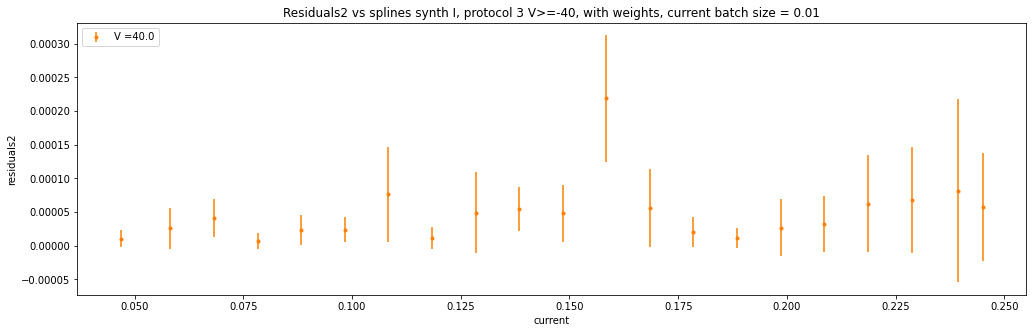

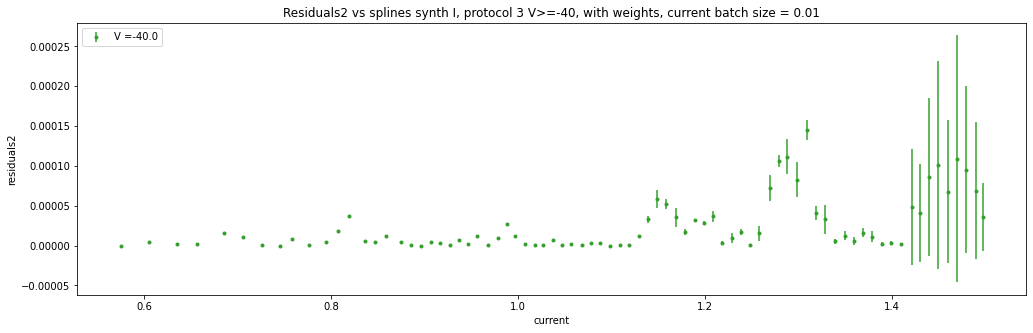

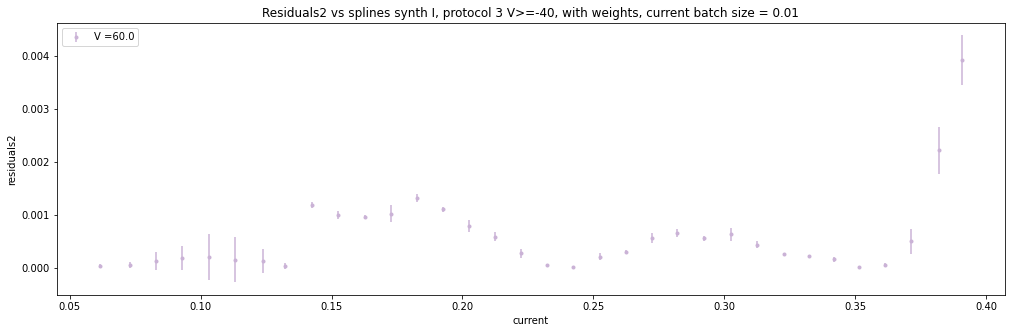

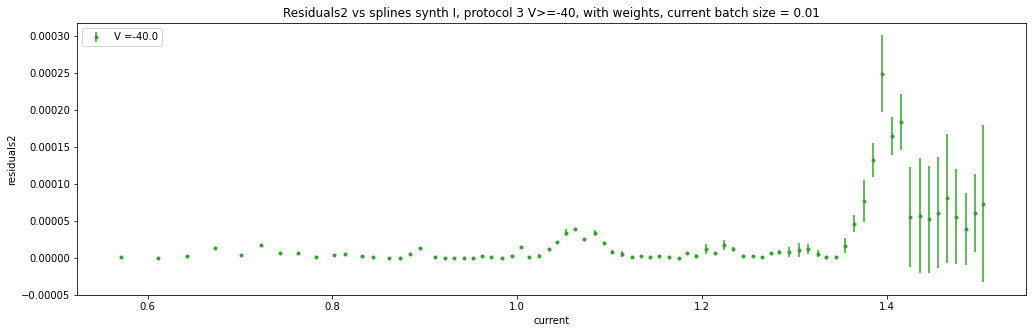

In [57]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
current_batch_size  = 0.01

I_grid_pr3_residuals2_largerCurrents_weights_bycurrent = [None] * len(index_largerCurrents)
I_ode_pr3_residuals2_largerCurrents_bycurrent = [None] * len(index_largerCurrents)

times_largerCurrents_weights_bycurrent = [None] * len(index_largerCurrents)
I_grid_pr3_splines_largerCurrents_weights_bycurrent = [None] * len(index_largerCurrents)
I_ode_pr3_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
I_grid_pr3_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
I_grid_pr3_largerCurrents_bycurrent_SORTindex = [None] * len(index_largerCurrents)

I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_meanbatch = [None] * len(index_largerCurrents)
I_grid_pr3_splines_largerCurrents_weights_bycurrent_meanbatch = [None] * len(index_largerCurrents)
I_ode_pr3_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
I_ode_pr3_residuals2_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
I_grid_pr3_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)

I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch = [None] * len(index_largerCurrents)
I_grid_pr3_splines_largerCurrents_weights_bycurrent_stdbatch = [None] * len(index_largerCurrents)
I_ode_pr3_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)
I_ode_pr3_residuals2_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)
I_grid_pr3_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    # find the index to surt the current
    I_grid_pr3_largerCurrents_bycurrent_SORTindex[index_i] = np.argsort(I_grid_pr3_splines_largerCurrents_weights[index_i])
    # arrange the vectors by current sort
    I_grid_pr3_largerCurrents_bycurrent[index_i] = I_grid_pr3_largerCurrents[index_i][I_grid_pr3_largerCurrents_bycurrent_SORTindex[index_i]]
    times_largerCurrents_weights_bycurrent[index_i] = times_largerCurrents[index_i][I_grid_pr3_largerCurrents_bycurrent_SORTindex[index_i]]
    I_grid_pr3_residuals2_largerCurrents_weights_bycurrent[index_i] = I_grid_pr3_residuals2_largerCurrents_weights[index_i][I_grid_pr3_largerCurrents_bycurrent_SORTindex[index_i]]
    I_ode_pr3_residuals2_largerCurrents_bycurrent[index_i] = I_ode_pr3_residuals2_largerCurrents[index_i][I_grid_pr3_largerCurrents_bycurrent_SORTindex[index_i]]
    I_grid_pr3_splines_largerCurrents_weights_bycurrent[index_i] = I_grid_pr3_splines_largerCurrents_weights[index_i][I_grid_pr3_largerCurrents_bycurrent_SORTindex[index_i]]
    I_ode_pr3_largerCurrents_bycurrent[index_i] = I_ode_pr3_largerCurrents[index_i][I_grid_pr3_largerCurrents_bycurrent_SORTindex[index_i]]
    # BATCHING:
    current_batches = np.arange(I_grid_pr3_splines_largerCurrents_weights_bycurrent[index_i][0],I_grid_pr3_splines_largerCurrents_weights_bycurrent[index_i][-1],current_batch_size)
    last_current_in_batch = np.zeros(len(current_batches)+1).astype(int)
    I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    I_ode_pr3_residuals2_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    I_grid_pr3_splines_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    I_ode_pr3_largerCurrents_bycurrent_meanbatch[index_i]= np.zeros(len(current_batches))
    I_grid_pr3_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    I_ode_pr3_residuals2_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    I_grid_pr3_splines_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    I_ode_pr3_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    I_grid_pr3_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    empty_batches =[]
    for i in range(len(current_batches)):
        # deal with the last interval
        if i == len(current_batches)-1:
            last_current_in_batch[i+1] = len(I_grid_pr3_splines_largerCurrents_weights_bycurrent[index_i])-1
        else:
            last_current_in_batch[i+1] = np.argmax(I_grid_pr3_splines_largerCurrents_weights_bycurrent[index_i]>current_batches[i+1])

        # dealing with the especial cases
        if last_current_in_batch[i+1] == last_current_in_batch[i]:
            # in case there is no point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])        
        elif last_current_in_batch[i+1]  == last_current_in_batch[i]+1:
            # in case there is onely one point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])
        else:
            I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i][i] = np.mean(I_grid_pr3_residuals2_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_ode_pr3_residuals2_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(I_ode_pr3_residuals2_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_splines_largerCurrents_weights_bycurrent_meanbatch[index_i][i] = np.mean(I_grid_pr3_splines_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_ode_pr3_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(I_ode_pr3_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(I_grid_pr3_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i][i] = np.std(I_grid_pr3_residuals2_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_ode_pr3_residuals2_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(I_ode_pr3_residuals2_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_splines_largerCurrents_weights_bycurrent_stdbatch[index_i][i] = np.std(I_grid_pr3_splines_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_ode_pr3_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(I_ode_pr3_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(I_grid_pr3_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
    if len(empty_batches)>0:
        print([index_i, np.shape(I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i]),len(empty_batches)])
        I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.delete(I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i],empty_batches)
        I_ode_pr3_residuals2_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(I_ode_pr3_residuals2_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        I_grid_pr3_splines_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.delete(I_grid_pr3_splines_largerCurrents_weights_bycurrent_meanbatch[index_i], empty_batches)
        I_ode_pr3_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(I_ode_pr3_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        I_grid_pr3_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(I_grid_pr3_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.delete(I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], empty_batches)
        I_ode_pr3_residuals2_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(I_ode_pr3_residuals2_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)
        I_grid_pr3_splines_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.delete(I_grid_pr3_splines_largerCurrents_weights_bycurrent_stdbatch[index_i],empty_batches)
        I_ode_pr3_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(I_ode_pr3_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)
        I_grid_pr3_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(I_grid_pr3_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)
        




plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(I_grid_pr3_splines_largerCurrents_weights_bycurrent[index_i],I_grid_pr3_residuals2_largerCurrents_weights_bycurrent[index_i], '.', color = pr3_voltage_constV_colors[i], alpha = 0.01, label = pr3_voltage_constV_labels_simple[i])
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2  vs splines sytnh I,protocol 3 sorted by current, with weights ')
    plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.errorbar(I_grid_pr3_splines_largerCurrents_weights_bycurrent_meanbatch[index_i], I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i], yerr=I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 vs splines synth I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.errorbar(I_ode_pr3_largerCurrents_bycurrent_meanbatch[index_i], I_ode_pr3_residuals2_largerCurrents_bycurrent_meanbatch[index_i], yerr=I_ode_pr3_residuals2_largerCurrents_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 vs ODE synth I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.errorbar(I_grid_pr3_splines_largerCurrents_weights_bycurrent_meanbatch[index_i], I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i], yerr=I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
plt.ylim([-0.00005, 0.0005])
plt.xlabel('current')
plt.ylabel('residuals2')
plt.title('Residuals2 vs splines synth I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
plt.legend(loc='upper left')
plt.show()

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.figure(figsize=(17, 5))
    plt.errorbar(I_grid_pr3_splines_largerCurrents_weights_bycurrent_meanbatch[index_i],I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i], yerr=I_grid_pr3_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_full[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 vs splines synth I, protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()


## Add independent noise

simulate an iid normal distributed with mean 0 and variance $$\epsilon^2 \approx 2.5 10^{-05}$$ from the data

0.005


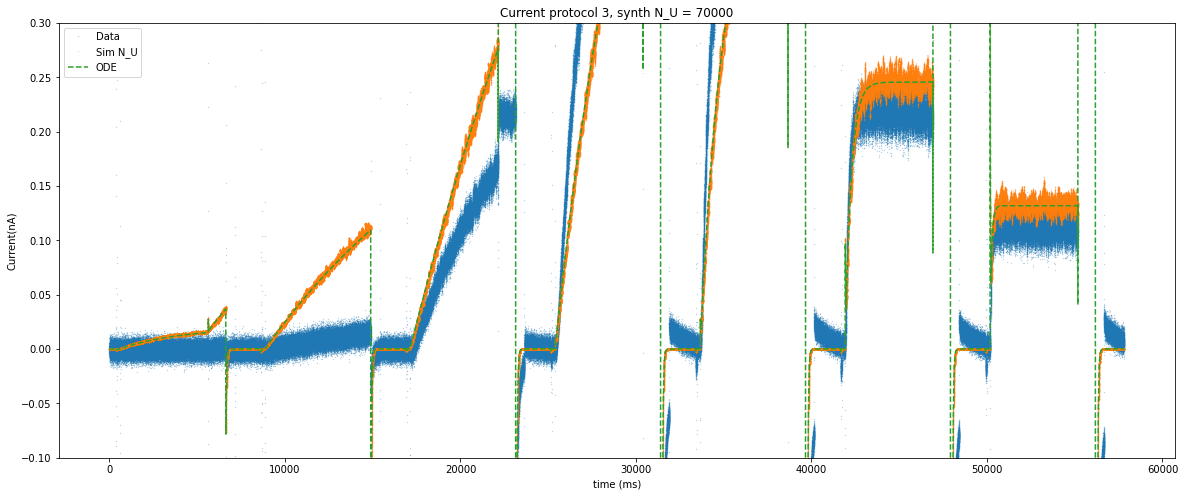

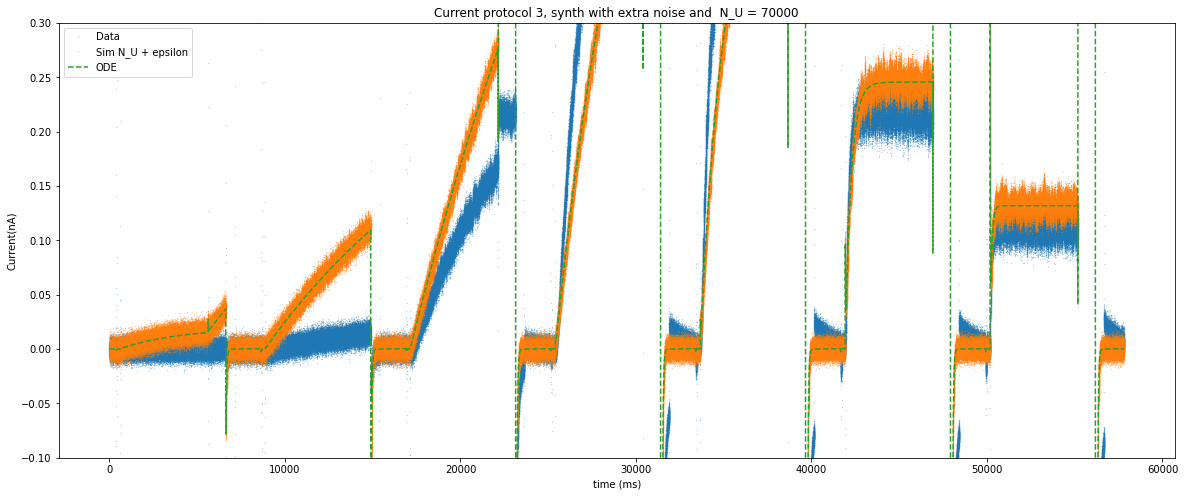

In [70]:
epsilon2 = 2.5e-05
print(np.sqrt(epsilon2))
# Random seed fixed in a cell before
epsilon_noise = np.random.normal(0, np.sqrt(epsilon2), len(I_grid_pr3_N_upper))

I_grid_pr3_withNoise = I_grid_pr3_N_upper + epsilon_noise
np.save(FileNameNLower + '_I_inter_withNoise_epsilon25e06.npy' , I_grid_pr3_withNoise)


plt.figure(figsize=(20, 8))
plt.plot(pr3_time, pr3_current,'.', markersize=0.5, alpha =0.5,  label='Data')
plt.plot(pr3_time, I_grid_pr3_N_upper ,'.', markersize=0.5, alpha =0.5, label='Sim N_U')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'],'--', drawstyle='steps-post', label='ODE')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, synth N_U = ' + str(N_upper))
plt.legend(loc='upper left')
plt.ylim(-.1, 0.3)

plt.show()

plt.figure(figsize=(20, 8))
plt.plot(pr3_time, pr3_current,'.', markersize=0.5, alpha =0.5,  label='Data')
plt.plot(pr3_time, I_grid_pr3_withNoise ,'.', markersize=0.5, alpha =0.5, label='Sim N_U + epsilon')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'],'--', drawstyle='steps-post', label='ODE')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, synth with extra noise and  N_U = ' + str(N_upper))
plt.legend(loc='upper left')
plt.ylim(-.1, .3)

plt.show()


In [71]:
# separate by current and by large currents the simulation + noise
I_grid_pr3_withNoise_constV = {}
I_grid_pr3_withNoise_constV_without_first5ms = {}
I_grid_pr3_withNoise_largerCurrents = [None] * len(index_largerCurrents)

I_grid_pr3_withNoise_residuals2_largerCurrents = [None] * len(index_largerCurrents)
I_ode_pr3_withNoise_residuals2_largerCurrents = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_splines_largerCurrents_weights = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_splines_params_largerCurrents_weights= [None] * len(index_largerCurrents)


for i in range(len(pr3_Vtimes)-1):
    I_grid_pr3_withNoise_constV[i]= I_grid_pr3_withNoise[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    I_grid_pr3_withNoise_constV_without_first5ms[i] = I_grid_pr3_withNoise[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    I_grid_pr3_withNoise_largerCurrents[index_i] = I_grid_pr3_withNoise_constV_without_first5ms[i]

In [73]:
# Find or load the splines parameters. NO WEIGHTS
if saved_splines_WithNoise:
    # Load the parameters of the spline:
    I_grid_pr3_withNoise_splines_params_largerCurrents_weights = np.load(FileNameNUpper + '_I_inter_par_splinesWeights_withNoise_epsilon25e06.npy')
    for index_i in range(len(index_largerCurrents)): 
        I_grid_pr3_withNoise_splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_withNoise_splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    print('Loading with weights DONE')
else:
    # CMA fit weights
    for index_i in range(len(index_largerCurrents)): 
        i=index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [I_grid_pr3_withNoise_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [I_grid_pr3_withNoise_largerCurrents[index_i][-1],I_grid_pr3_withNoise_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i], NumExpo_flag], options = optscma)
        I_grid_pr3_withNoise_splines_params_largerCurrents_weights[index_i] = es[0]
        I_grid_pr3_withNoise_splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_withNoise_splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    # SAVE THE PARAMETERS
    np.save(FileNameNUpper + '_I_inter_par_splinesWeights_withNoise_epsilon25e06.npy',np.array(I_grid_pr3_withNoise_splines_params_largerCurrents_weights))
    print('Fitting with weights DONE')

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=896029, Mon Nov  1 09:17:39 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 4.529440091834807e+01 1.0e+00 9.01e-01  9e-01  9e-01 0:00.0
    2     20 3.551537374194135e+01 1.2e+00 8.48e-01  8e-01  9e-01 0:00.0
    3     30 2.312335348196379e+00 1.3e+00 7.81e-01  7e-01  8e-01 0:00.1
  100   1000 9.713715410592369e-04 1.2e+02 4.04e-02  2e-02  7e-02 0:01.5
  200   2000 3.630997302110268e-04 4.7e+03 5.10e-02  2e-03  4e-01 0:02.9
  300   3000 2.309273001933271e-04 3.4e+04 4.19e-03  1e-05  4e-02 0:04.3
  400   4000 2.254909231448890e-04 5.7e+04 8.03e-02  9e-05  3e-01 0:05.7
  500   5000 2.191677563735866e-04 1.2e+05 3.69e-03  1e-06  1e-02 0:07.1
NOTE (module=cma, iteration=552):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 4.3e+10 to 3.6e+10
  600   6000 2.191664489680384e-04 7.4e+05 1.51e-02  2e-06  1e-01 0:08.5


/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=612)
  warnings.warn(msg + ' (' +


  700   7000 2.191555763451385e-04 3.9e+01 8.06e-02  3e-02  2e-01 0:10.0
  800   8000 2.190867232107379e-04 4.6e+02 4.03e-01  1e-01  2e+00 0:11.5
  900   9000 2.189750761245245e-04 1.6e+03 7.12e-01  1e-01  3e+00 0:13.0
 1000  10000 2.189549176908743e-04 4.4e+03 3.28e-01  3e-02  8e-01 0:14.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 2.189258772164301e-04 5.7e+03 3.05e+00  1e-01  4e+00 0:16.0
 1200  12000 2.189018798690350e-04 6.2e+03 4.27e+00  9e-02  3e+00 0:17.7
 1300  13000 2.188826023825979e-04 3.8e+03 9.29e+00  1e-01  3e+00 0:19.3
 1400  14000 2.188661970070403e-04 1.8e+03 1.27e+01  5e-02  2e+00 0:21.0
 1500  15000 2.188544135668130e-04 1.2e+03 2.00e+01  5e-02  1e+00 0:22.7
 1600  16000 2.188461514275421e-04 2.3e+03 3.10e+01  4e-02  1e+00 0:24.5
 1700  17000 2.188396006335715e-04 5.8e+03 7.94e+01  7e-02  2e+00 0:26.2
 1800  18000 2.188349357123762e-04 1.2e+04 1.43e+02  8e-02  2e+00 0:27.9
 1900  19000 2.188304862537403e-04 2.8e+04 1.51e+02 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=424)
  warnings.warn(msg + ' (' +


  500   5000 3.148363965016872e-04 1.3e+02 5.15e-01  3e-01  2e+00 0:42.4
  600   6000 3.144669181721799e-04 8.2e+02 6.72e-03  2e-03  1e-02 0:50.7
  630   6300 3.144669146383561e-04 1.2e+03 9.54e-04  2e-04  1e-03 0:53.1
termination on tolfun=1e-11 (Mon Nov  1 09:28:03 2021)
final/bestever f-value = 3.144669e-04 3.144669e-04
incumbent solution: [ 2.33224574e-01  4.55997964e+00  5.97366547e+03 -4.79324674e+00
  6.09752913e+03  5.52952692e-04  2.93190813e+03  9.15977129e-04 ...]
std deviations: [0.00038607 0.00058214 0.00105134 0.00106424 0.00123231 0.00030921
 0.00103537 0.00024323 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=882707, Mon Nov  1 09:28:03 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 9.328586818484130e+00 1.0e+00 9.99e-01  1e+00  1e+00 0:00.1
    2     20 3.641085533718645e+01 1.2e+00 9.50e-01  9e-01  1e+00 0:00.1
    3     30 1.629718162535311e+01 1.3e+00 8.69e-01  8e-01  9e-01 0:00.2
   55    550 5.556678665095

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=638)
  warnings.warn(msg + ' (' +


  700   7000 1.036375277282425e-03 2.1e+01 4.23e-01  2e-01  1e+00 0:49.2
  800   8000 1.036011376913897e-03 3.1e+02 1.41e+00  8e-01  9e+00 0:55.8
  900   9000 1.035669332741226e-03 1.3e+03 3.26e+00  1e+00  1e+01 1:02.6
 1000  10000 1.035571306465874e-03 5.0e+03 4.38e+00  1e+00  2e+01 1:09.3
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.035539529466080e-03 1.1e+04 5.26e+00  1e+00  1e+01 1:15.7
 1200  12000 1.035528529788622e-03 1.2e+04 6.37e+00  1e+00  6e+00 1:22.3
 1300  13000 1.035524528882395e-03 2.5e+04 9.59e+00  9e-01  7e+00 1:29.0
 1400  14000 1.035523085906106e-03 3.3e+04 2.31e+01  9e-01  1e+01 1:35.5
 1500  15000 1.035522221213804e-03 5.2e+04 4.83e+01  9e-01  1e+01 1:42.0
 1600  16000 1.035521573191337e-03 7.2e+04 4.25e+01  3e-01  6e+00 1:48.5
 1700  17000 1.035521121712561e-03 1.0e+05 1.38e+02  6e-01  1e+01 1:54.9
 1800  18000 1.035520571421237e-03 1.2e+05 2.48e+02  6e-01  2e+01 2:01.4
 1900  19000 1.035520150463373e-03 9.0e+04 3.19e+02 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=619)
  warnings.warn(msg + ' (' +


  700   7000 3.331558577884232e-03 4.5e+01 5.29e-01  4e-01  7e-01 0:09.7
  800   8000 3.151134508912504e-03 4.2e+02 2.70e+00  2e+00  1e+01 0:11.1
  900   9000 3.063980431322631e-03 5.1e+03 2.73e+00  3e+00  2e+01 0:12.4
 1000  10000 3.031229334587811e-03 9.0e+03 1.02e+01  5e+00  3e+01 0:13.8
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 3.009591337488402e-03 4.5e+04 7.89e+00  2e+00  2e+01 0:15.3
 1200  12000 2.997804881714908e-03 1.2e+05 1.70e+01  3e+00  5e+01 0:16.9
 1300  13000 2.992127018779671e-03 3.1e+05 3.35e+01  3e+00  7e+01 0:18.5
 1400  14000 2.990112840860937e-03 7.1e+05 5.51e+01  2e+00  6e+01 0:20.2
 1500  15000 2.989320325802676e-03 2.6e+06 1.21e+02  5e+00  1e+02 0:21.8
 1600  16000 2.988345578988485e-03 5.2e+06 2.72e+02  5e+00  2e+02 0:23.4
 1700  17000 2.953515931144175e-03 2.7e+06 4.26e+02  3e+00  1e+02 0:25.1
 1800  18000 2.854514016344887e-03 6.5e+06 1.79e+03  9e+00  7e+02 0:26.7
 1803  18030 2.838874802049024e-03 8.0e+06 2.35e+03 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=617)
  warnings.warn(msg + ' (' +


  700   7000 3.094551944116775e-03 2.5e+01 2.14e-02  1e-02  4e-02 0:41.4
  800   8000 3.094470497502122e-03 3.0e+03 7.03e-01  7e-01  4e+01 0:47.6
  900   9000 3.094005419872803e-03 1.4e+04 3.32e+00  1e+00  9e+01 0:53.8
 1000  10000 3.091890347668600e-03 2.0e+04 1.10e+01  2e+00  1e+02 1:00.0
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 3.077323427182652e-03 2.0e+04 4.50e+01  6e+00  1e+02 1:06.2
 1200  12000 3.068190730246239e-03 7.6e+04 5.27e+01  7e+00  2e+02 1:12.4
 1300  13000 3.065309856087213e-03 1.9e+05 5.05e+01  6e+00  1e+02 1:18.9
 1400  14000 3.064748397598333e-03 1.4e+05 1.09e+02  9e+00  8e+01 1:25.4
 1500  15000 3.064043118790767e-03 1.7e+05 9.32e+01  5e+00  4e+01 1:31.9
 1600  16000 3.063756870464930e-03 1.6e+05 1.60e+02  6e+00  4e+01 1:38.2
 1700  17000 3.063677582553022e-03 8.8e+04 2.41e+02  3e+00  1e+01 1:44.7
 1800  18000 3.063610999847865e-03 2.6e+05 3.04e+02  2e+00  2e+01 1:51.3
 1900  19000 3.063575388337969e-03 1.6e+05 3.77e+02 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1150)
  warnings.warn(msg + ' (' +


 1200  12000 1.124913540905132e-02 1.7e+01 4.96e+00  4e+00  2e+01 0:17.7
 1300  13000 1.124053898808563e-02 6.8e+01 1.09e+01  9e+00  4e+01 0:19.3
 1400  14000 1.123978285098251e-02 2.4e+02 2.47e-01  1e-01  5e-01 0:21.0
 1430  14300 1.123978284795571e-02 3.1e+02 5.28e-02  2e-02  1e-01 0:21.5
termination on tolfun=1e-11 (Mon Nov  1 09:59:54 2021)
final/bestever f-value = 1.123978e-02 1.123978e-02
incumbent solution: [ 9.13500029e-01  4.07362449e-02  5.53093060e+02  4.18903197e-02
  5.64348554e+02 -4.66707617e-02  3.60383341e+01 -4.37968779e-01 ...]
std deviations: [0.01997821 0.0312533  0.06252773 0.02319107 0.10164293 0.03413835
 0.03903011 0.08930726 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=910130, Mon Nov  1 09:59:54 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 7.088242302492922e+00 1.0e+00 8.94e-01  9e-01  9e-01 0:00.1
    2     20 1.337111977771772e+01 1.1e+00 9.25e-01  9e-01  1e+00 0:00.1
    3     30 2.320460832172

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=664)
  warnings.warn(msg + ' (' +


  700   7000 6.757298629543365e-03 9.8e+00 1.04e+00  7e-01  2e+00 0:44.8
  800   8000 6.740255509585774e-03 1.6e+02 1.89e+00  1e+00  6e+00 0:52.2
  900   9000 6.722776809310815e-03 5.5e+02 3.42e+00  1e+00  8e+00 0:59.8
 1000  10000 6.704065153012161e-03 1.9e+03 8.02e+00  2e+00  2e+01 1:07.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 6.699860391533599e-03 4.3e+03 9.15e-01  2e-01  1e+00 1:14.7
 1200  12000 6.699807717561501e-03 6.8e+04 9.90e+00  4e+00  8e+01 1:22.0
 1300  13000 6.699343492798076e-03 9.2e+04 3.31e+01  8e+00  2e+02 1:29.6
 1400  14000 6.698418412892255e-03 9.6e+04 7.61e+01  6e+00  3e+02 1:36.9
 1500  15000 6.695620622388266e-03 6.8e+04 9.99e+01  3e+00  2e+02 1:44.3
 1600  16000 6.694601078624175e-03 7.4e+04 3.26e+02  6e+00  2e+02 1:51.8
 1700  17000 6.693153618704426e-03 2.1e+04 5.32e+02  4e+00  6e+01 1:59.1
 1800  18000 6.690976687828841e-03 2.0e+04 1.13e+03  6e+00  5e+01 2:06.6
 1900  19000 6.689102944014908e-03 1.7e+04 2.28e+03 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=907)
  warnings.warn(msg + ' (' +


 1000  10000 1.523558211045542e-02 4.8e+01 1.33e+01  7e+00  3e+01 0:16.5
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.377283074867483e-02 9.2e+02 2.02e+01  1e+01  1e+02 0:18.1
 1200  12000 1.352146653191925e-02 5.7e+03 3.08e+01  2e+01  3e+02 0:19.9
 1300  13000 1.344098904055847e-02 2.8e+04 3.43e+01  1e+01  3e+02 0:21.8
 1400  14000 1.340640903271444e-02 7.4e+04 6.07e+01  9e+00  3e+02 0:23.5
 1500  15000 1.338457521767316e-02 1.4e+05 1.43e+02  1e+01  3e+02 0:25.2
 1600  16000 1.334462287844991e-02 2.7e+05 1.64e+02  1e+01  3e+02 0:27.0
 1700  17000 1.334266079137582e-02 6.7e+05 1.43e+02  5e+00  2e+02 0:28.8
 1800  18000 1.333968340913504e-02 5.0e+05 3.83e+02  5e+00  2e+02 0:30.7
 1900  19000 1.333720124302012e-02 7.7e+05 7.97e+02  6e+00  3e+02 0:32.5
 2000  20000 1.333566635781835e-02 1.4e+06 1.41e+03  6e+00  4e+02 0:34.3
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 2100  21000 1.333455762529071e-02 2.5e+06 1.80e+03  

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=706)
  warnings.warn(msg + ' (' +


  800   8000 1.702805845386932e-02 5.3e+01 1.34e+00  5e-01  7e+00 0:59.8
  900   9000 1.701297367047805e-02 7.3e+02 4.45e+00  2e+00  5e+01 1:07.0
 1000  10000 1.689640787132425e-02 3.2e+03 1.54e+01  5e+00  1e+02 1:14.3
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.649694039264294e-02 9.0e+03 7.35e+01  2e+01  2e+02 1:21.7
 1200  12000 1.602463785333176e-02 2.6e+04 6.38e+01  9e+00  7e+01 1:29.3
 1300  13000 1.582912463599593e-02 3.4e+04 1.18e+02  1e+01  7e+01 1:36.6
 1400  14000 1.576534391697363e-02 7.8e+04 1.15e+02  7e+00  6e+01 1:44.1
 1500  15000 1.573722759345206e-02 1.4e+05 2.25e+02  1e+01  1e+02 1:51.5
 1600  16000 1.572838814946119e-02 2.5e+05 1.68e+02  5e+00  7e+01 1:58.7
 1700  17000 1.572388979046604e-02 4.1e+05 4.57e+02  1e+01  1e+02 2:06.1
 1800  18000 1.572155115743384e-02 6.4e+05 3.33e+02  4e+00  6e+01 2:13.7
 1900  19000 1.571987941436234e-02 7.9e+05 5.09e+02  4e+00  7e+01 2:21.0
 2000  20000 1.571881899884308e-02 1.1e+06 1.55e+03 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=547)
  warnings.warn(msg + ' (' +


  600   6000 1.376518531028897e-02 2.0e+01 4.11e-01  2e-01  9e-01 0:10.3
  700   7000 1.369495964314345e-02 7.7e+01 1.38e+00  2e-01  4e+00 0:11.9
  800   8000 1.298903404825962e-02 2.1e+02 4.72e+00  7e-01  1e+01 0:13.6
  900   9000 1.207047948915325e-02 4.5e+02 1.43e+01  3e+00  2e+01 0:15.5
 1000  10000 1.156084999462253e-02 4.6e+03 1.73e+01  2e+00  7e+01 0:17.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.141671605213324e-02 1.6e+04 2.08e+01  2e+00  7e+01 0:18.8
 1200  12000 1.136978992050409e-02 2.8e+04 2.39e+01  2e+00  5e+01 0:20.5
 1300  13000 1.134894764079425e-02 4.1e+04 5.46e+01  3e+00  6e+01 0:22.4
 1400  14000 1.133768274226261e-02 5.7e+04 7.73e+01  3e+00  4e+01 0:24.2
 1500  15000 1.132994681983018e-02 9.5e+04 1.35e+02  3e+00  4e+01 0:25.7
 1600  16000 1.132301882558650e-02 1.7e+05 3.06e+02  3e+00  6e+01 0:27.4
 1700  17000 1.130260262847719e-02 3.5e+05 4.39e+02  3e+00  8e+01 0:29.1
 1800  18000 1.124831971381643e-02 2.6e+05 5.90e+02 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1162)
  warnings.warn(msg + ' (' +


 1200  12000 1.056108734665353e-01 8.2e+00 2.34e+01  2e+01  4e+01 1:25.5
 1300  13000 1.055904441134639e-01 1.5e+02 6.41e+01  2e+01  2e+02 1:32.3
 1400  14000 1.054749796262559e-01 8.2e+01 2.02e+02  3e+01  3e+02 1:39.4
 1455  14550 1.052463350680541e-01 7.0e+02 2.64e+02  3e+01  1e+03 1:43.6
termination on tolfacupx=1000.0 (Mon Nov  1 10:28:43 2021)
final/bestever f-value = 1.052536e-01 1.052463e-01
incumbent solution: [ 1.31193142e-01  2.82932099e-02  1.04912247e+02  2.51501944e-04
  2.23612836e+03 -6.17759473e+00  3.82424389e+01  6.41426534e+00 ...]
std deviations: [  32.5831921   127.58348243  201.70596767  385.11635429  195.82234114
 1140.5565659   440.96168295   26.18580027 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=867434, Mon Nov  1 10:28:43 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 4.835843447805561e+01 1.0e+00 9.17e-01  9e-01  9e-01 0:00.0
    2     20 2.513048894056656e+01 1.2e+00 8.75e-01  8e-01  9e-01 0:00.0

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=491)
  warnings.warn(msg + ' (' +


  500   5000 1.027548787691685e-02 1.9e+00 6.51e-02  6e-02  7e-02 0:09.0
  600   6000 1.027513678043704e-02 1.9e+02 5.53e-02  2e-02  5e-01 0:10.8
  700   7000 1.027473502225911e-02 3.9e+03 1.84e-01  3e-02  2e+00 0:12.4
  800   8000 1.027370821463986e-02 2.8e+03 5.03e-01  8e-02  2e+00 0:13.9
  900   9000 1.026679048826514e-02 3.3e+04 2.74e+00  1e+00  2e+01 0:15.5
 1000  10000 1.025498631913611e-02 1.6e+05 1.05e+00  3e-01  7e+00 0:17.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.025040801851476e-02 2.6e+05 1.37e+01  1e+00  3e+01 0:19.0
 1200  12000 1.024402737163367e-02 4.3e+05 3.50e+01  1e+00  4e+01 0:20.7
 1300  13000 1.023690362083569e-02 3.4e+06 9.51e+01  3e+00  3e+02 0:22.4
 1357  13570 1.023332972834809e-02 1.0e+07 8.48e+01  6e+00  4e+02 0:23.4
termination on tolconditioncov=100000000000000.0 (Mon Nov  1 10:30:07 2021)
final/bestever f-value = 1.023345e-02 1.023333e-02
incumbent solution: [-9.73494440e+00  2.38200944e+02  5.04705916e+03 -2

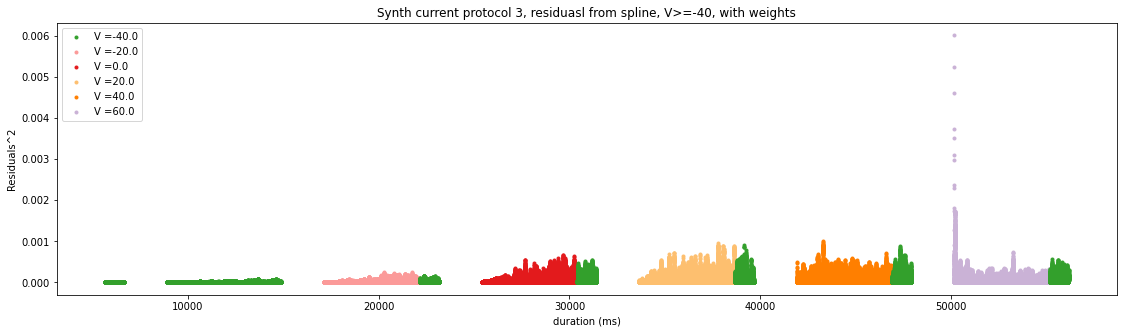

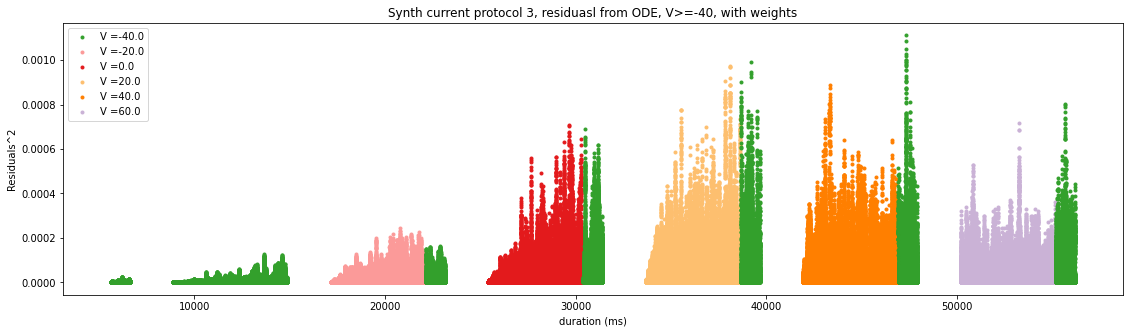

In [79]:
# get the residuals

I_grid_pr3_withNoise_residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)
I_ode_pr3_withNoise_residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)


plt.figure(figsize=(19, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    residuals = I_grid_pr3_largerCurrents[index_i] - I_grid_pr3_withNoise_splines_largerCurrents_weights[index_i]
    I_grid_pr3_withNoise_residuals2_largerCurrents_weights[index_i] = residuals ** 2
    residuals = I_grid_pr3_largerCurrents[index_i] - I_ode_pr3_largerCurrents[index_i]
    I_ode_pr3_withNoise_residuals2_largerCurrents_weights[index_i] = residuals ** 2
    plt.plot(times_largerCurrents[index_i], I_grid_pr3_withNoise_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Synth current protocol 3, residuasl from spline, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()



plt.figure(figsize=(19, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], I_ode_pr3_withNoise_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Synth current protocol 3, residuasl from ODE, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

In [81]:
# Bin by current

# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
current_batch_size  = 0.01

I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent = [None] * len(index_largerCurrents)
I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent = [None] * len(index_largerCurrents)

times_largerCurrents_withNoise_weights_bycurrent = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent = [None] * len(index_largerCurrents)
I_ode_pr3_withNoise_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_largerCurrents_bycurrent_SORTindex = [None] * len(index_largerCurrents)

I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_meanbatch = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_meanbatch = [None] * len(index_largerCurrents)
I_ode_pr3_withNoise_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)

I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_stdbatch = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_stdbatch = [None] * len(index_largerCurrents)
I_ode_pr3_withNoise_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)
I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)
I_grid_pr3_withNoise_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)



for index_i in range(len(index_largerCurrents)):
    # find the index to surt the current
    I_grid_pr3_withNoise_largerCurrents_bycurrent_SORTindex[index_i] = np.argsort(I_grid_pr3_withNoise_splines_largerCurrents_weights[index_i])
    # arrange the vectors by current sort
    I_grid_pr3_withNoise_largerCurrents_bycurrent[index_i] = I_grid_pr3_withNoise_largerCurrents[index_i][I_grid_pr3_withNoise_largerCurrents_bycurrent_SORTindex[index_i]]
    times_largerCurrents_withNoise_weights_bycurrent[index_i] = times_largerCurrents[index_i][I_grid_pr3_withNoise_largerCurrents_bycurrent_SORTindex[index_i]]
    I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent[index_i] = I_grid_pr3_withNoise_residuals2_largerCurrents_weights[index_i][I_grid_pr3_withNoise_largerCurrents_bycurrent_SORTindex[index_i]]
    I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent[index_i] = I_ode_pr3_withNoise_residuals2_largerCurrents[index_i][I_grid_pr3_withNoise_largerCurrents_bycurrent_SORTindex[index_i]]
    I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent[index_i] = I_grid_pr3_withNoise_splines_largerCurrents_weights[index_i][I_grid_pr3_withNoise_largerCurrents_bycurrent_SORTindex[index_i]]
    I_ode_pr3_withNoise_largerCurrents_bycurrent[index_i] = I_ode_pr3_largerCurrents[index_i][I_grid_pr3_withNoise_largerCurrents_bycurrent_SORTindex[index_i]]
    # BATCHING:
    current_batches = np.arange(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent[index_i][0],I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent[index_i][-1],current_batch_size)
    last_current_in_batch = np.zeros(len(current_batches)+1).astype(int)
    I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    I_ode_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i]= np.zeros(len(current_batches))
    I_grid_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    I_ode_pr3_withNoise_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    I_grid_pr3_withNoise_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    empty_batches =[]
    for i in range(len(current_batches)):
        # deal with the last interval
        if i == len(current_batches)-1:
            last_current_in_batch[i+1] = len(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent[index_i])-1
        else:
            last_current_in_batch[i+1] = np.argmax(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent[index_i]>current_batches[i+1])

        # dealing with the especial cases
        if last_current_in_batch[i+1] == last_current_in_batch[i]:
            # in case there is no point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])        
        elif last_current_in_batch[i+1]  == last_current_in_batch[i]+1:
            # in case there is onely one point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])
        else:
            I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i][i] = np.mean(I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_meanbatch[index_i][i] = np.mean(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_ode_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(I_ode_pr3_withNoise_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(I_grid_pr3_withNoise_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i][i] = np.std(I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_stdbatch[index_i][i] = np.std(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_ode_pr3_withNoise_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(I_ode_pr3_withNoise_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            I_grid_pr3_withNoise_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(I_grid_pr3_withNoise_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
    if len(empty_batches)>0:
        print([index_i, np.shape(I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i]),len(empty_batches)])
        I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.delete(I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i],empty_batches)
        I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.delete(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_meanbatch[index_i], empty_batches)
        I_ode_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(I_ode_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        I_grid_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(I_grid_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.delete(I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], empty_batches)
        I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)
        I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.delete(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_stdbatch[index_i],empty_batches)
        I_ode_pr3_withNoise_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(I_ode_pr3_withNoise_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)
        I_grid_pr3_withNoise_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(I_grid_pr3_withNoise_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)
        


[7, (84,), 9]
[9, (93,), 14]
[11, (94,), 17]


In [ ]:
plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.errorbar(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_meanbatch[index_i], I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i], yerr=I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 vs splines synth I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.errorbar(I_ode_pr3_withNoise_largerCurrents_bycurrent_meanbatch[index_i], I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_meanbatch[index_i], yerr=I_ode_pr3_withNoise_residuals2_largerCurrents_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 vs ODE synth I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.errorbar(I_grid_pr3_withNoise_splines_largerCurrents_weights_bycurrent_meanbatch[index_i], I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i], yerr=I_grid_pr3_withNoise_residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
plt.ylim([-0.00005, 0.0005])
plt.xlabel('current')
plt.ylabel('residuals2')
plt.title('Residuals2 vs splines synth I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
plt.legend(loc='upper left')
plt.show()

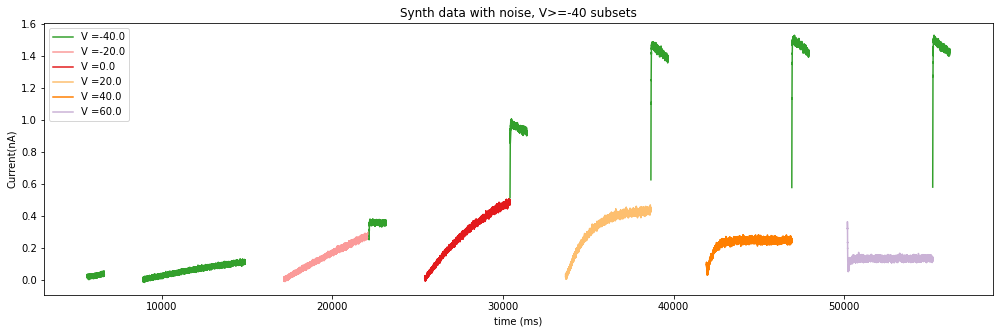

In [76]:
plt.figure(figsize=(17, 5))
#plt.plot(pr3_time, pr3_current,':', label='Full protocol')
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], I_grid_pr3_withNoise_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Synth data with noise, V>=-40 subsets')
    plt.legend(loc='upper left')
#plt.savefig('pr3_cell5_current_largecurrents.png', transparent = False, dpi = 150)
plt.show()